In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [2]:
import numpy as np
import pickle
from tabulate import tabulate
from functools import partial
import ctypes
from scipy.optimize import minimize, LinearConstraint, dual_annealing, Bounds, NonlinearConstraint
from scipy.stats import truncnorm
import scipy.stats as stats
from scipy.stats.qmc import Sobol, Halton
import matplotlib.pyplot as plt
import matplotlib as mpl
import nlopt 
import multiprocessing, tqdm
from bgspy.likelihood import negll_c, negll, negll_numba
from bgspy.likelihood import bounds_simplex, random_start_simplex, random_start_mutation
from bgspy.likelihood import negll_mutation, bounds_mutation
from bgspy.likelihood import penalized_negll_c

In [327]:
def nloptim_summary(run_res, nt, nf, mle_rank=0, nll=None):
    nlls, thetas, success = run_res
    ranks = np.argsort(nlls)
    best_idx = ranks[mle_rank]
    theta = thetas[best_idx]
    # if we're a parameter short, assume μ is fixed
    dim = theta.size
    fixedmu = dim == nt * nf + 1
    print(fixedmu, dim)
    nll = nlls[best_idx]
    status, counts = np.unique(success, return_counts=True)
    n = len(success)
    stat_codes = {1:'success', 2:'stopval reached', 3:'ftol reached', 
                  4:'xtol reached', 5:'max eval', 6:'maxtime reached', -1:'failure',
                  -2:'invalid args', -3:'out of memory', -4:'forced stop'}
    print("exist status stats: " + ','.join([f"{stat_codes[i]} = {np.round(c/n, 2)*100}%" for i, c in zip(status, counts)]))
    print(f"exists: ")
    print(f"NLL: {nll}\npi0: {theta[0]}\n")
    if not fixedmu:
        print(f"μ: {theta[1]}\nW = ")
        o = 2
    else:
        print(f"μ: --fixed?--\nW = ")
        o = 1
    W = theta[o:].reshape((nt, nf))
    print(tabulate(np.round(W, 3)))
    print(f"sums: {W.sum(axis=0)}")
    return theta


def summarize_optims(res):
    # for scipy
    nlls, thetas, success = res
    x = thetas[np.argmin(nlls)]
    ll = np.min(nlls) / 1e11
    pi0 = x[0]
    w = x[2:]/x[2:].sum()
    mu = x[2:].sum()
    print(f"convergence: {np.round(np.mean(success), 2)*100}%")
    print(f"neg loglik (x1e11) = {ll}\nμ = {mu}\nπ0 = {pi0}\nw = {w}\n")
    return x

def check_bounds(x, lb, ub):
    assert np.all((x >= lb) & (x <= ub))

In [4]:
plt.rcParams['figure.figsize'] = [8, 4]
plt.rcParams['figure.dpi'] = 200
plt.style.use('./buffalo.mplstyle')

# Fitting and Testing Optimization Procedures

Note that we often have to define specific fitting functions and run those — annoyingly when using Python's multiprocessing module, there's an issue where closures (functions that define functions around values) do not pickle and thus cannot be shipped off to other cores safely. So each test relies on a custom test function.

## Load data and define some functions

In [238]:
dat = pickle.load(open('../tests/likelihood_test_data.pkl', 'rb'))
B, Bp, Y, w = dat['B'], dat['Bp'], dat['Y'], dat['w']
bins = dat['bins']

nx, nw, nt, nf = B.shape
nparams = nt * nf + 2

In [239]:
set(chroms)

{1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22}

### EDA of the Count Data / π

In [240]:
def optim_plot(tail=0.5, **runs):
    fig, ax = plt.subplots()
    for i, (key, run) in enumerate(runs.items()):
        nll = run[0]
        succ = run[2]
        q = np.quantile(nll, tail)
        nlls = nll[nll < q]
        sort_idx = np.argsort(nlls)
        y = nlls[sort_idx]
        x = 2*i + succ[nll < q].astype('int')
        cols = mpl.cm.get_cmap('Paired')(x)
        ax.scatter(list(reversed(range(len(y)))), y, s=1, label=key, c=cols)
    ax.legend()

In [241]:
Y[idx,:].sum(axis=1)

array([1.03092295e+10, 3.77659920e+10, 3.63165351e+10, ...,
       4.22796237e+10, 3.35806224e+10, 3.41438046e+10])

/tmp/ipykernel_10842/1848201972.py:10: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(x[idx], Y[idx, 1] / Y[idx,:].sum(axis=1), label=chrom)
/tmp/ipykernel_10842/1848201972.py:10: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(x[idx], Y[idx, 1] / Y[idx,:].sum(axis=1), label=chrom)
/tmp/ipykernel_10842/1848201972.py:10: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(x[idx], Y[idx, 1] / Y[idx,:].sum(axis=1), label=chrom)
/tmp/ipykernel_10842/1848201972.py:10: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(x[idx], Y[idx, 1] / Y[idx,:].sum(axis=1), label=chrom)
/tmp/ipykernel_10842/1848201972.py:10: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(x[idx], Y[idx, 1] / Y[idx,:].sum(axis=1), label=chrom)
/tmp/ipykernel_10842/1848201972.py:10: RuntimeWarning: invalid value encountered in true_divide
  plt.plot(x[idx], Y[idx, 1] / Y[idx,:].sum(axis=1), label=chrom)
/tmp/ipykernel_10842/1848201

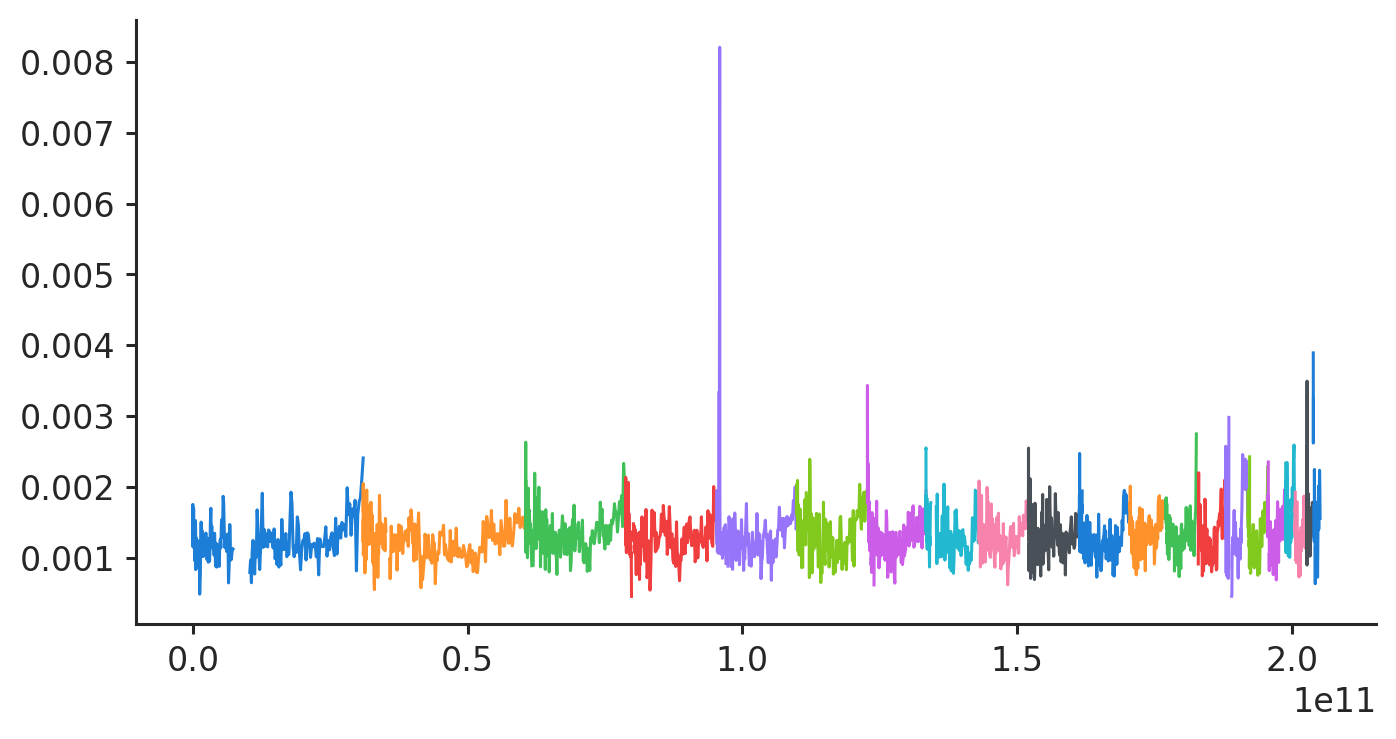

In [215]:
def chromplot(bins, Y, scatter=False):
    chroms = np.array([int(chrom.replace('chr', '')) for chrom, pos in bins])
    mps = np.array([int(pos) for chrom, pos in bins])
    x = np.cumsum(mps)
    for chrom in set(chroms):
        idx = chrom == chroms
        if scatter:
            plt.plot(x[idx], Y[idx, 1] / Y[idx,:].sum(axis=1), label=chrom)
        else:
            plt.plot(x[idx], Y[idx, 1] / Y[idx,:].sum(axis=1), label=chrom)
        
chromplot(bins, Y)

/tmp/ipykernel_10842/914613212.py:2: RuntimeWarning: invalid value encountered in true_divide
  pi = Y[:, 1] / Y[:,:].sum(axis=1)


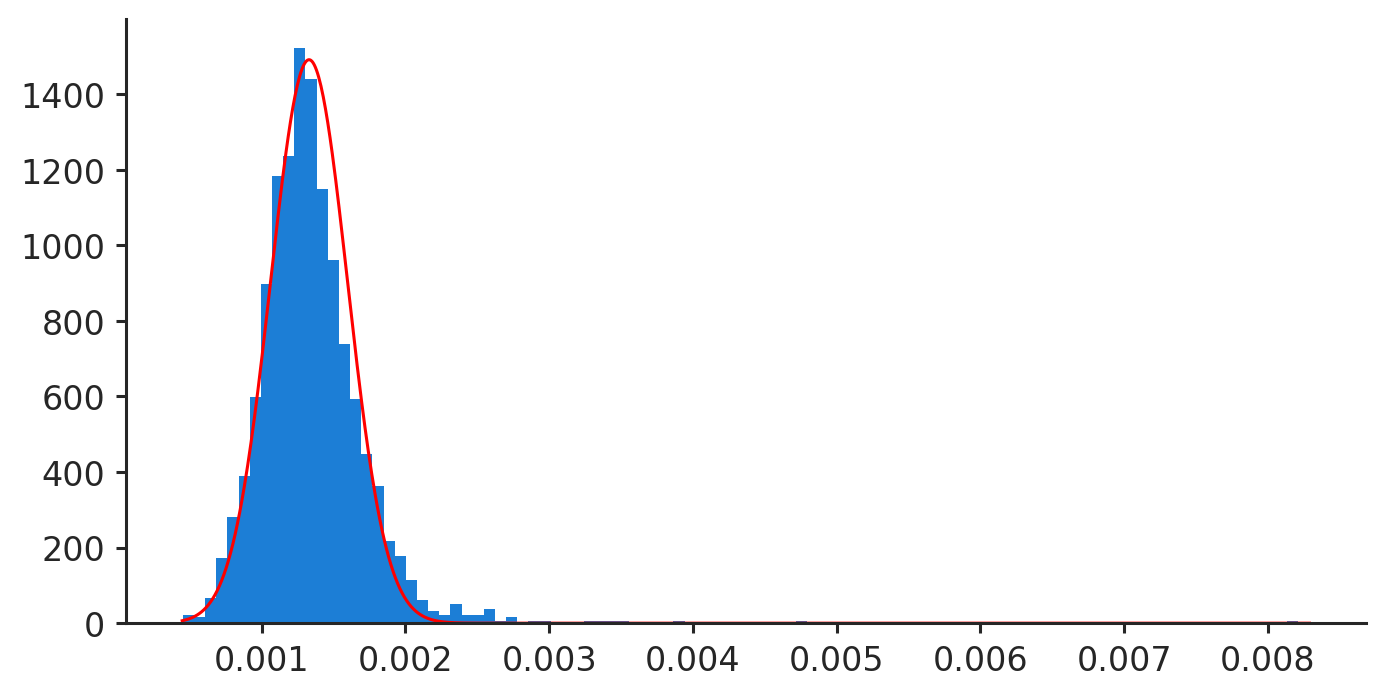

In [216]:
def Y_hist(Y, nbins=100):
    pi = Y[:, 1] / Y[:,:].sum(axis=1)
    _ = plt.hist(pi, nbins, density=True)
    idx = (np.nanquantile(pi, alpha/2) < pi) & (np.nanquantile(pi, 1-alpha/2) > pi)
    z = np.linspace(np.nanmin(pi)*0.99, np.nanmax(pi)*1.01, 1000)
    xt = pi[idx]
    plt.plot(z, stats.norm(loc=np.nanmean(xt), scale=np.nanstd(xt)).pdf(z), c='r')
    
Y_hist(Y)

/tmp/ipykernel_10842/1752429494.py:6: RuntimeWarning: invalid value encountered in true_divide
  pi = Y[:, 1] / Y[:,:].sum(axis=1)


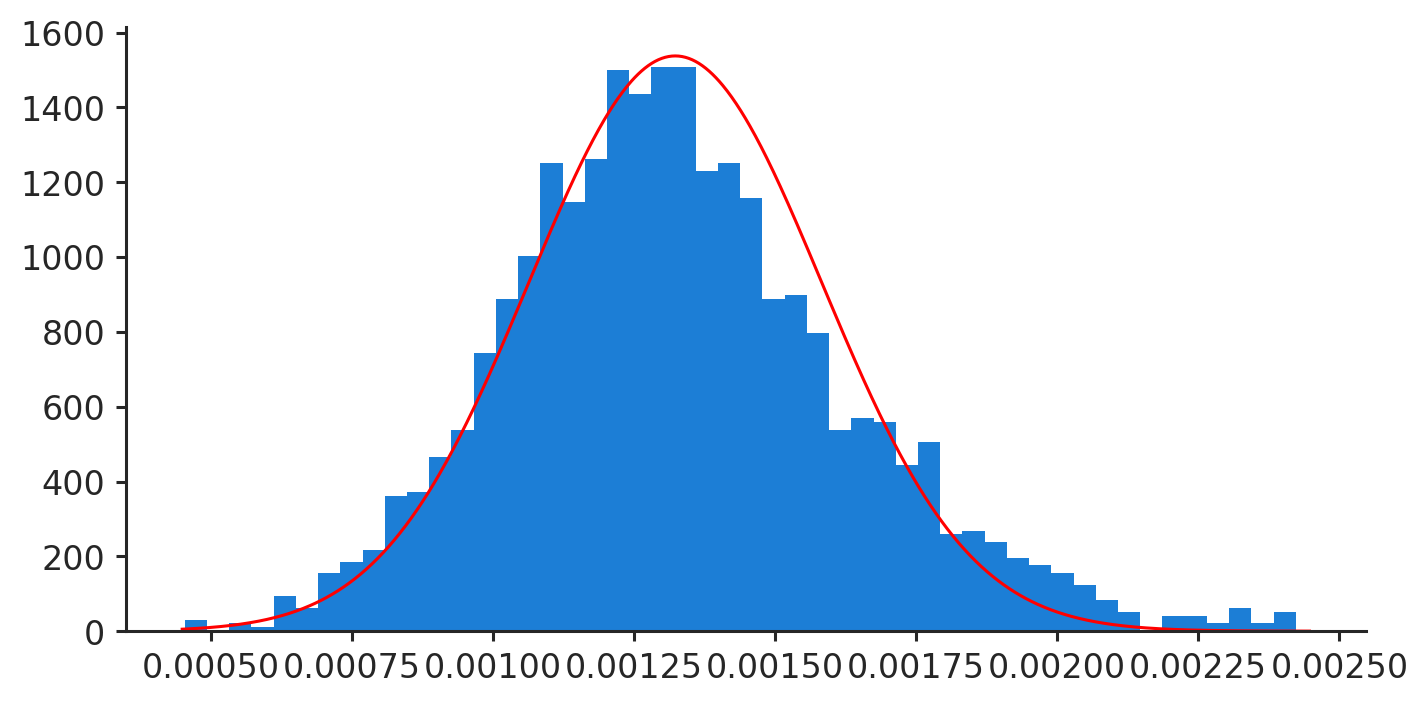

In [243]:
def filter_Y(Y, bins, alpha=0.01):
    if isinstance(alpha, float):
        lower, upper = alpha/2, 1-alpha/2
    else:
        lower, upper = alpha
    pi = Y[:, 1] / Y[:,:].sum(axis=1)
    idx = (np.nanquantile(pi, lower) < pi) & (np.nanquantile(pi, upper) > pi)
    bins = [b for keep, b in zip(idx, bins) if keep]
    return bins, Y[idx, :], idx

binsf, Yf, idx = filter_Y(Y, bins=bins, alpha=(0.0, 0.99))
Y_hist(Yf, nbins=50)

In [244]:
(Y.shape[0] - Yf.shape[0]) / Y.shape[0]

0.08630952380952381

In [245]:
Yf.shape[0], len(binsf)

(2456, 2456)

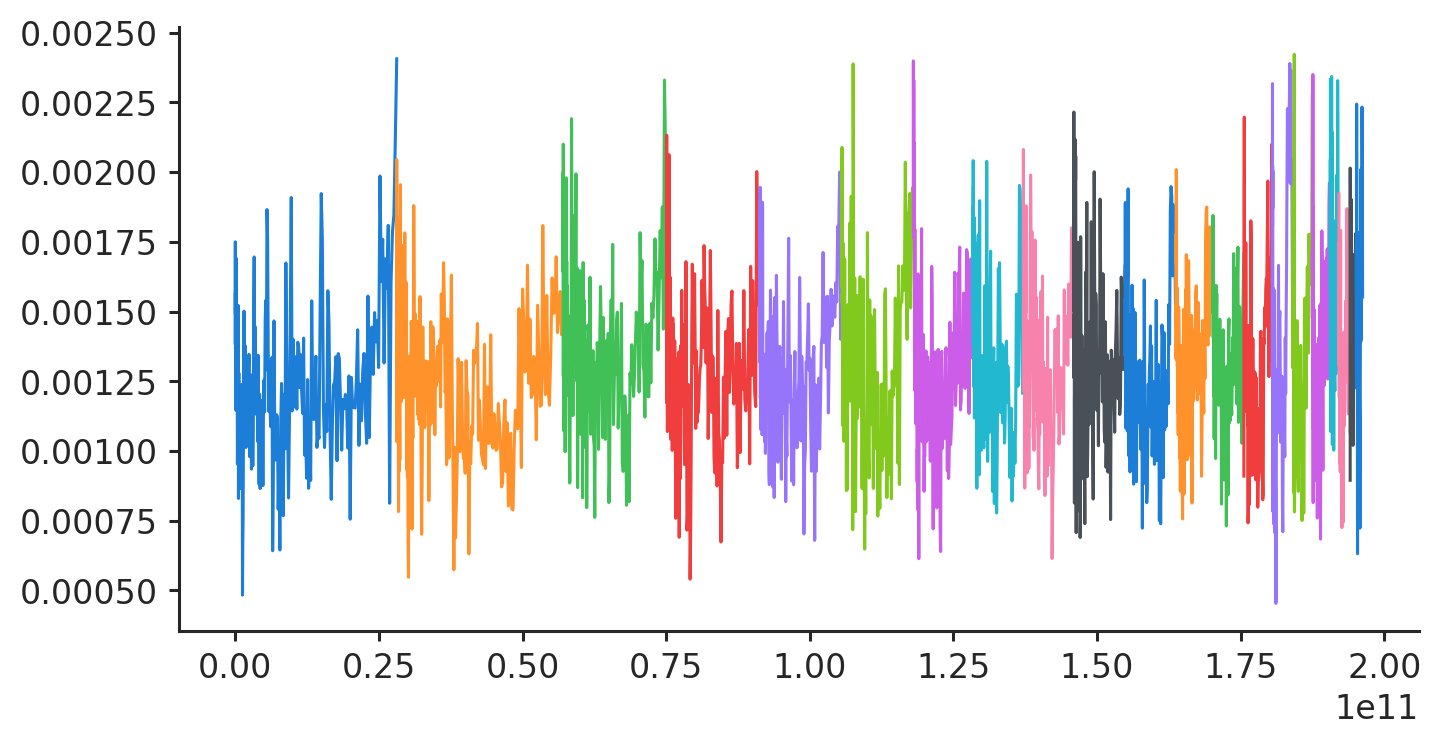

In [246]:
chromplot(binsf, Yf, scatter=True)

In [247]:
Yorig = Y
Y = Yf
Bp = Bp[idx, ...]

In [248]:
assert Bp.shape[0] == Y.shape[0]

# Free-Mutation Model (SciPy)

Here we try a less-constrained form of optimization: a separate mutation rate per feature/selection class. This minimizes constraints — all we need are bounds. But, there are an extra two degrees of freedom. The simpler constraints mean that SciPy's optimiation function will work fine.

## Free-Mutation Model with Reduced Features Model

Here we try the simplest test case: only one column of features (CDS) of the test human data.
 

In [7]:
def negll_freemut(Y, B, w):
    def func(theta):
        new_theta = np.zeros(theta.size + 1)
        new_theta[0] = theta[0]
        # fix mutation rate to one and let W represent mutation rates to various classes
        new_theta[1] = 1.
        new_theta[2:] = theta[1:] # times mutation rates        
        return negll_c(new_theta, Y, B, w)
    return func

def run_optims(workerfunc, startfunc, nstarts, ncores = 50):
    starts = [startfunc() for _ in range(nstarts)]
    with multiprocessing.Pool(ncores) as p:
        res = list(tqdm.tqdm(p.imap(workerfunc, starts), total=nstarts))
    nlls = np.array([x.fun for x in res])
    thetas = np.array([x.x for x in res])
    success = np.array([x.success for x in res])
    return nlls, thetas, success
    

In [60]:
nllBp = negll_freemut(Y, Bp[..., 0][..., None], w)
nllB = negll_freemut(Y, B[..., 0][..., None], w)


def worker_Bp_reduced(start):
    return minimize(nllBp, x0=start, bounds=bounds_mutation(nt, 1, paired=True), method='L-BFGS-B')

def worker_B_reduced(start):
    return minimize(nllB, x0=start, bounds=bounds_mutation(nt, 1, paired=True), method='L-BFGS-B')

resB_reduced = run_optims(worker_B_reduced, partial(random_start_mutation, nt, 1), 1000)
resBp_reduced = run_optims(worker_Bp_reduced, partial(random_start_mutation, nt, 1), 1000)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:55<00:00,  8.63it/s]


In [54]:
summarize_optims(resB_reduced)
summarize_optims(resBp_reduced)

convergence: 86.0%
neg loglik (x1e11) = 9.135707071705916
μ = 9.563630082935192e-08
π0 = 0.0018976206388014861
w = [6.62607879e-01 2.39507301e-01 1.04562806e-04 1.04562806e-04
 1.04562806e-04 1.04562806e-04 1.04562806e-04 2.63681686e-04
 1.38641070e-03 1.12688330e-02 1.00492391e-02 4.20878359e-02
 1.74590083e-02 1.48469976e-02]

convergence: 81.0%
neg loglik (x1e11) = 9.135709413339473
μ = 6.050563618297347e-08
π0 = 0.00185718862851748
w = [4.16332534e-01 4.18378630e-01 2.71537475e-03 4.15983920e-04
 4.08758082e-03 2.71537475e-03 4.20061095e-04 4.43810424e-03
 5.88162759e-03 1.60016380e-02 8.71945182e-03 4.33599083e-02
 4.61695086e-02 3.03642221e-02]



[]

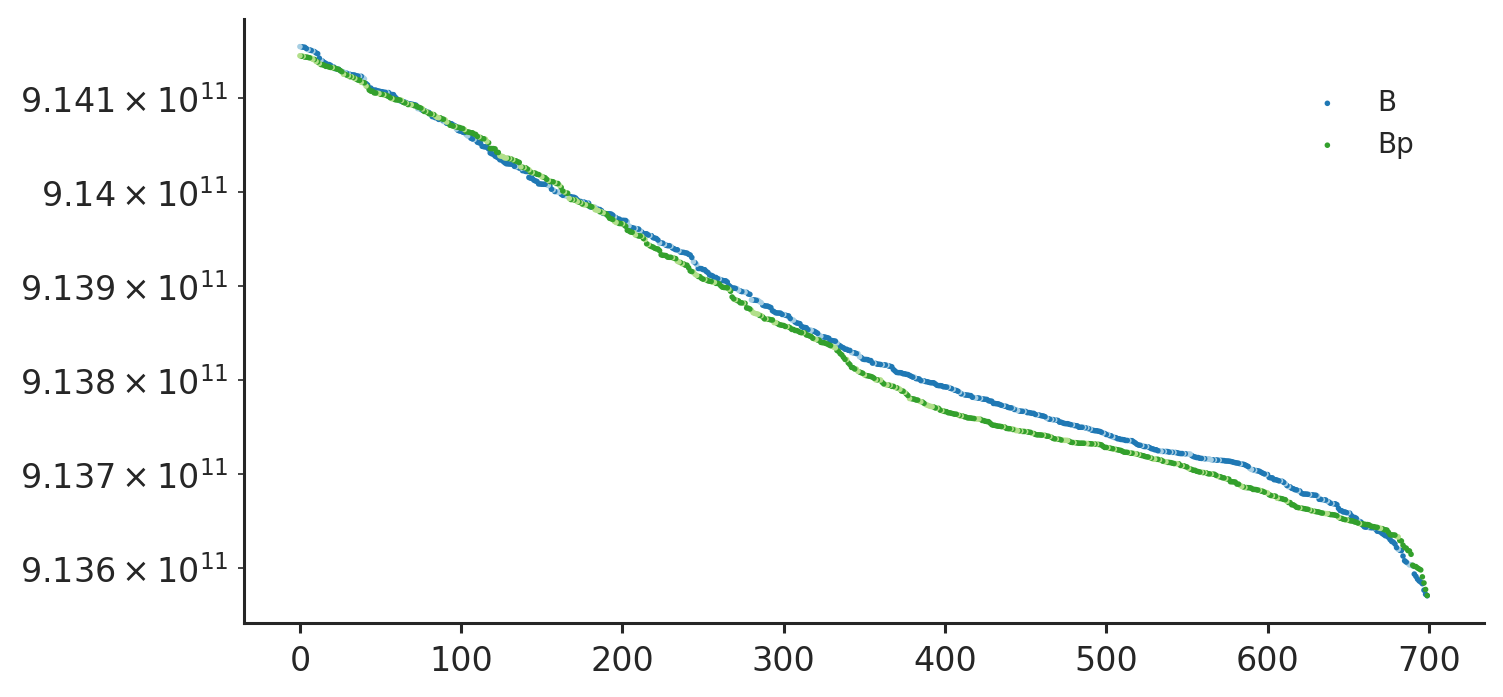

In [56]:
optim_plot(B=resB_reduced, Bp=resBp_reduced, tail=0.7)
plt.semilogy()

## Free-Mutation Model (All Features)

In [48]:
nllBp = negll_freemut(Y, Bp, w)
nllB = negll_freemut(Y, B, w)

def worker_Bp_full(start):
    return minimize(nllBp, x0=start, bounds=bounds_mutation(nt, nf, paired=True), method='L-BFGS-B')

def worker_B_full(start):
    return minimize(nllB, x0=start, bounds=bounds_mutation(nt, nf, paired=True), method='L-BFGS-B')

resB = run_optims(worker_Bp_full, partial(random_start_mutation, nt, nf), 1000)
resBp = run_optims(worker_Bp_full, partial(random_start_mutation, nt, nf), 1000)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1000/1000 [03:44<00:00,  4.45it/s]


In [500]:
summarize_optims(resB)
bt2 = summarize_optims(resBp)

convergence: 86.0%
neg loglik (x1e11) = 9.135707071705916
μ = 9.563630082935192e-08
π0 = 0.0018976206388014861
w = [6.62607879e-01 2.39507301e-01 1.04562806e-04 1.04562806e-04
 1.04562806e-04 1.04562806e-04 1.04562806e-04 2.63681686e-04
 1.38641070e-03 1.12688330e-02 1.00492391e-02 4.20878359e-02
 1.74590083e-02 1.48469976e-02]

convergence: 81.0%
neg loglik (x1e11) = 9.135709413339473
μ = 6.050563618297347e-08
π0 = 0.00185718862851748
w = [4.16332534e-01 4.18378630e-01 2.71537475e-03 4.15983920e-04
 4.08758082e-03 2.71537475e-03 4.20061095e-04 4.43810424e-03
 5.88162759e-03 1.60016380e-02 8.71945182e-03 4.33599083e-02
 4.61695086e-02 3.03642221e-02]



[]

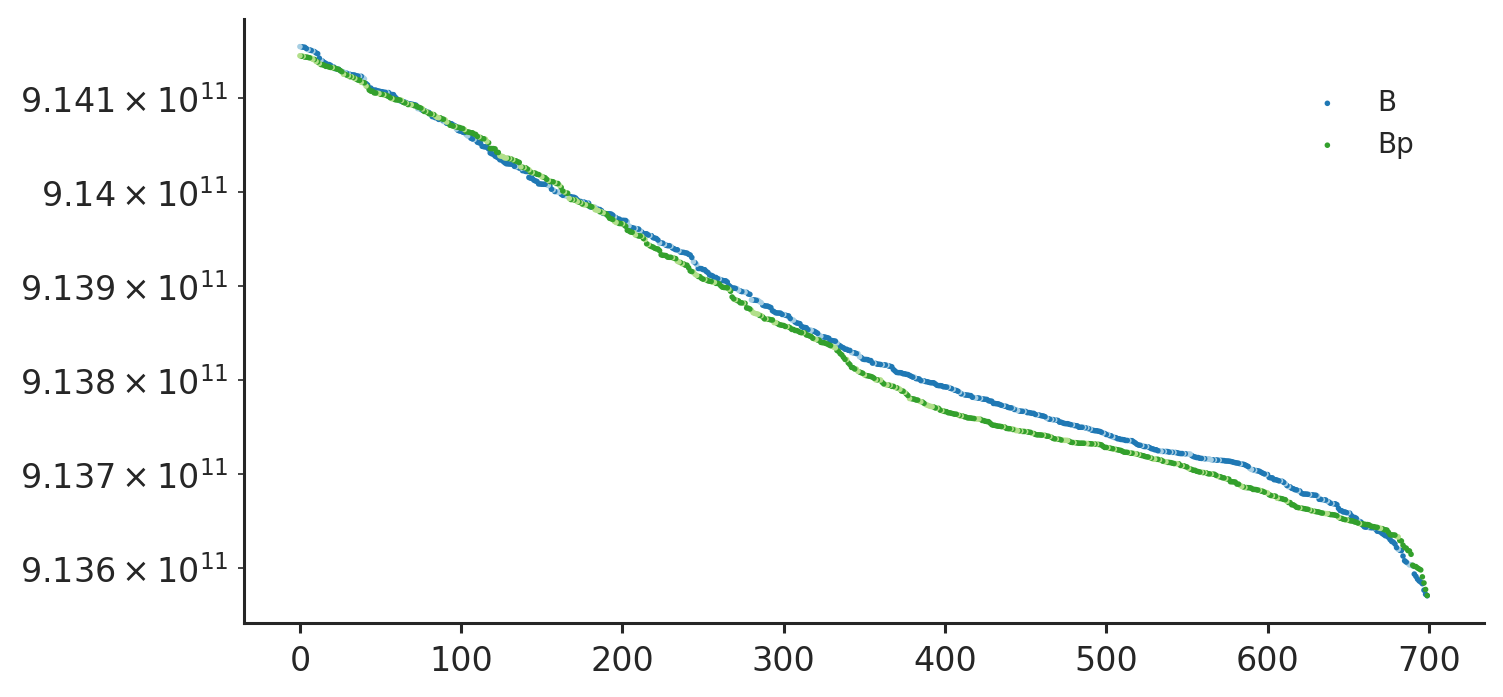

In [62]:
optim_plot(B=resB, Bp=resBp, tail=0.7)
plt.semilogy()

# Simplex Model (NLOpt)

The simplex model is an $n_t \times n_f$ matrix $\mathbf{W}$ which are DFE weights (columns sum to 1). The mutation rate per selection class, per feature class is then $\mu \mathbf{W}$.

The bounds of $\mathbf{W}$ are $[0, 1]$, and the constraint is $\sum_j w_{i,j} = 1$ However, there is also a total mutation bound, $\mu_l \le \mu \le \mu_u$. So, 

$$ \mu_l \le \mu \mathbf{W} \le \mu_u$$

In [249]:
def negll_nlopt(Y, B, w):
    # NLOPT needs to accept a grad argument
    def func(x, grad):
        return negll_c(x, Y, B, w)
    return func


def run_nloptims(workerfunc, startfunc, nstarts, ncores = 70):
    starts = [startfunc() for _ in range(nstarts)]
    with multiprocessing.Pool(ncores) as p:
        res = list(tqdm.tqdm(p.imap(workerfunc, starts), total=nstarts))
    nlls = np.array([x[0] for x in res])
    thetas = np.array([x[1] for x in res])
    success = np.array([x[2] for x in res])
    return nlls, thetas, success

In [250]:
def constraint_matrix(nt, nf):
    nparams = nt*nf + 2
    A = np.zeros((nf, nparams))
    for i in range(nf):
        W = A[i, 2:].reshape((nt, nf))
        W[:, i] = 1.
    return A

def inequality_constraint_functions(nt, nf, log10_mu_bounds=(-11, -7)):
    """
     l < u W < u
     l - uW < 0
     u W - u < 0
    """
    A = constraint_matrix(nt, nf)
    lower, upper = 10**log10_mu_bounds[0], 10**log10_mu_bounds[1]
    def func_l(result, x, grad):
        #x = x[0]
        mu = x[1]
        M = lower - (mu *  A.dot(x))
        for i in range(nf):
            result[i] = M[i]
    def func_u(result, x, grad):
        #x = x[0]
        mu = x[1]
        M = (mu *  A.dot(x)) - upper
        for i in range(nf):
            result[i] = M[i]
    return func_l, func_u

def equality_constraint_function(nt, nf):
    A = constraint_matrix(nt, nf)
    def func(result, x, grad):
        M = A.dot(x)
        for i in range(nf):
            result[i] = M[i] - 1.
    return func

## A simple NLOpt single run test

In [225]:
Y.shape, Bp.shape

((2456, 2), (2456, 6, 5, 3))

In [226]:
hl, hu = inequality_constraint_functions(nt, nf)
ce = equality_constraint_function(nt, nf)

# NOTE: we do not have a start-based test of these bounds
# because it looks like SWIG's interface to NLOPT wraps this in a 
# weird way

In [227]:
# specify the algorithm
#opt = nlopt.opt(nlopt.LN_COBYLA, nparams)
opt = nlopt.opt(nlopt.GN_ISRES, nparams)

# create a closure around the data
nll = negll_nlopt(Y, Bp, w)

# set the objective
opt.set_min_objective(nll) 

# specify tolerances and constraints
tols = np.repeat(1e-12, nf)
opt.add_inequality_mconstraint(hl, tols)
opt.add_inequality_mconstraint(hu, tols)
opt.add_equality_mconstraint(ce, tols)

# set bounds
lb, ub = bounds_simplex(nt, nf)
opt.set_lower_bounds(lb)
opt.set_upper_bounds(ub)

In [229]:
%%time
np.random.seed(1231)
# stopping criteria:
#opt.set_xtol_abs(np.array([1e-4, 1e-10] + [1e-04] * nt*nf))
opt.set_xtol_rel(1e-3)
#opt.set_ftol_abs(1e8)
#opt.set_stopval(923543002497)
opt.set_maxeval(10000000)

# random start
x = random_start_simplex(nt, nf)
assert x.size == nparams

# run
res = opt.optimize(x)

CPU times: user 17min 37s, sys: 104 ms, total: 17min 37s
Wall time: 17min 37s


In [231]:
# mle theta, nll:
res, opt.last_optimum_value(), opt.last_optimize_result()

(array([1.85053608e-03, 4.09050182e-09, 1.17338623e-02, 5.17532899e-01,
        1.04041703e-01, 7.04673947e-02, 8.92167163e-02, 1.79361907e-02,
        2.44654500e-03, 3.77542574e-04, 9.15361018e-02, 1.61219465e-01,
        2.06287448e-01, 5.55324886e-01, 7.54132733e-01, 1.86585394e-01,
        2.31161119e-01]),
 901214111566.2308,
 4)

In [232]:
res[0], res[1], np.round(res[2:].reshape((nt, nf)), 2), opt.last_optimum_value()

(0.0018505360814673095,
 4.090501816840227e-09,
 array([[0.01, 0.52, 0.1 ],
        [0.07, 0.09, 0.02],
        [0.  , 0.  , 0.09],
        [0.16, 0.21, 0.56],
        [0.75, 0.19, 0.23]]),
 901214111566.2308)

In [35]:
opt.get_initial_step(x)

array([5.01770929e-04, 1.93937491e-10, 2.50000000e-01, 2.50000000e-01,
       7.65917530e-03, 1.01580488e-01, 1.39766915e-02, 1.57985518e-01,
       1.65902250e-03, 1.08987313e-02, 1.57259939e-01, 2.50000000e-01,
       2.50000000e-01, 2.50000000e-01, 1.22138093e-01, 8.81828925e-02,
       1.39449460e-01])

## Exploratory ISRES Global Runs

In [15]:
# this wraps the nloptimization call
def nlopt_isres_worker(x, nt, nf):
    nparams = nt*nf + 2
    opt = nlopt.opt(nlopt.GN_ISRES, nparams)
    #opt = nlopt.opt(nlopt.AUGLAG, nparams)
    #opt.set_local_optimizer(nlopt.LN_COBYLA)
    nll = negll_nlopt(Y, Bp, w)
    opt.set_min_objective(nll) 
    hl, hu = inequality_constraint_functions(nt, nf)
    tols = np.repeat(1e-11, nf)
    opt.add_inequality_mconstraint(hl, tols)
    opt.add_inequality_mconstraint(hu, tols)
    ce = equality_constraint_function(nt, nf)
    opt.add_equality_mconstraint(ce, tols)
    lb, ub = bounds_simplex(nt, nf)
    opt.set_lower_bounds(lb)
    opt.set_upper_bounds(ub)
    opt.set_xtol_rel(1e-3)
    #opt.set_xtol_abs(1e-6)
    #opt.set_stopval(923543002497)
    opt.set_maxeval(1000000)
    assert x.size == nparams
    mle = opt.optimize(x)
    nll = opt.last_optimum_value()
    success = opt.last_optimize_result()
    return nll, mle, success

In [237]:
%%time
N = 1

np.random.seed(0)
worker = partial(nlopt_isres_worker, nt=nt, nf=nf)
isres_run_res = run_nloptims(worker, partial(random_start_simplex, nt=nt, nf=nf), N)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [16:04<00:00, 964.49s/it]

CPU times: user 210 ms, sys: 1.73 s, total: 1.94 s
Wall time: 16min 6s


In [254]:
best_theta = nloptim_summary(isres_run_res, nt, nf) # isres run

exist status stats: xtol reached = 100.0%
exists: 
NLL: 901227971250.2604
pi0: 0.0018199696597345743

μ: 4.7579085874440635e-09
W = 
-----  -----  -----
0.239  0.298  0.541
0.012  0.003  0.075
0.09   0.171  0
0.212  0.016  0.101
0.448  0.513  0.283
-----  -----  -----
sums: [1. 1. 1.]


In [17]:
nloptim_summary(isres_run_res, nt, nf) # isres run

exist status stats: xtol reached = 100.0%
exists: 
NLL: 913580008000.8599
pi0: 0.0018640241856986194

μ: 3.908748533540473e-09
W = 
-----  -----  -----
0.006  0.248  0.216
0.071  0.098  0.003
0      0.004  0.298
0.257  0.165  0.324
0.666  0.484  0.16
-----  -----  -----
sums: [1. 1. 1.]


array([1.86402419e-03, 3.90874853e-09, 5.78687454e-03, 2.48047105e-01,
       2.15864591e-01, 7.09784188e-02, 9.82936943e-02, 2.66744885e-03,
       5.37695774e-09, 4.30014646e-03, 2.98036441e-01, 2.57384010e-01,
       1.65408950e-01, 3.23736649e-01, 6.65850691e-01, 4.83950104e-01,
       1.59694870e-01])

In [61]:
nloptim_summary(isres_run_res, nt, nf) # isres run

exist status stats: max eval = 100.0%
exists: 
NLL: 913555328334.137
pi0: 0.0019099386326876559

μ: 5.078090688055941e-09
W = 
-----  -----  -----
0.118  0.555  0.349
0.055  0.075  0.035
0.003  0      0.036
0.098  0      0.444
0.726  0.37   0.136
-----  -----  -----
sums: [1. 1. 1.]


array([1.90993863e-03, 5.07809069e-09, 1.18152265e-01, 5.55089861e-01,
       3.48673529e-01, 5.46142328e-02, 7.47558666e-02, 3.51835472e-02,
       3.35102024e-03, 1.88075652e-04, 3.55842194e-02, 9.77870754e-02,
       1.36991718e-04, 4.44223967e-01, 7.26095406e-01, 3.69829205e-01,
       1.36334737e-01])

In [53]:
nloptim_summary(isres_run_res, nt, nf) # isres run

exist status stats: xtol reached = 100.0%
exists: 
NLL: 913544453562.5887
pi0: 0.001923425036014099

μ: 4.787731863988657e-09
W = 
-----  -----  -----
0      0.574  0.373
0.055  0.064  0.049
0.048  0      0.094
0      0.208  0.049
0.897  0.154  0.436
-----  -----  -----
sums: [1. 1. 1.]


array([1.92342504e-03, 4.78773186e-09, 5.23467255e-05, 5.73863831e-01,
       3.72533407e-01, 5.50218690e-02, 6.40994218e-02, 4.93733558e-02,
       4.79533488e-02, 2.79577009e-04, 9.36809575e-02, 6.02833557e-05,
       2.07726583e-01, 4.87604633e-02, 8.96912152e-01, 1.54030587e-01,
       4.35651817e-01])

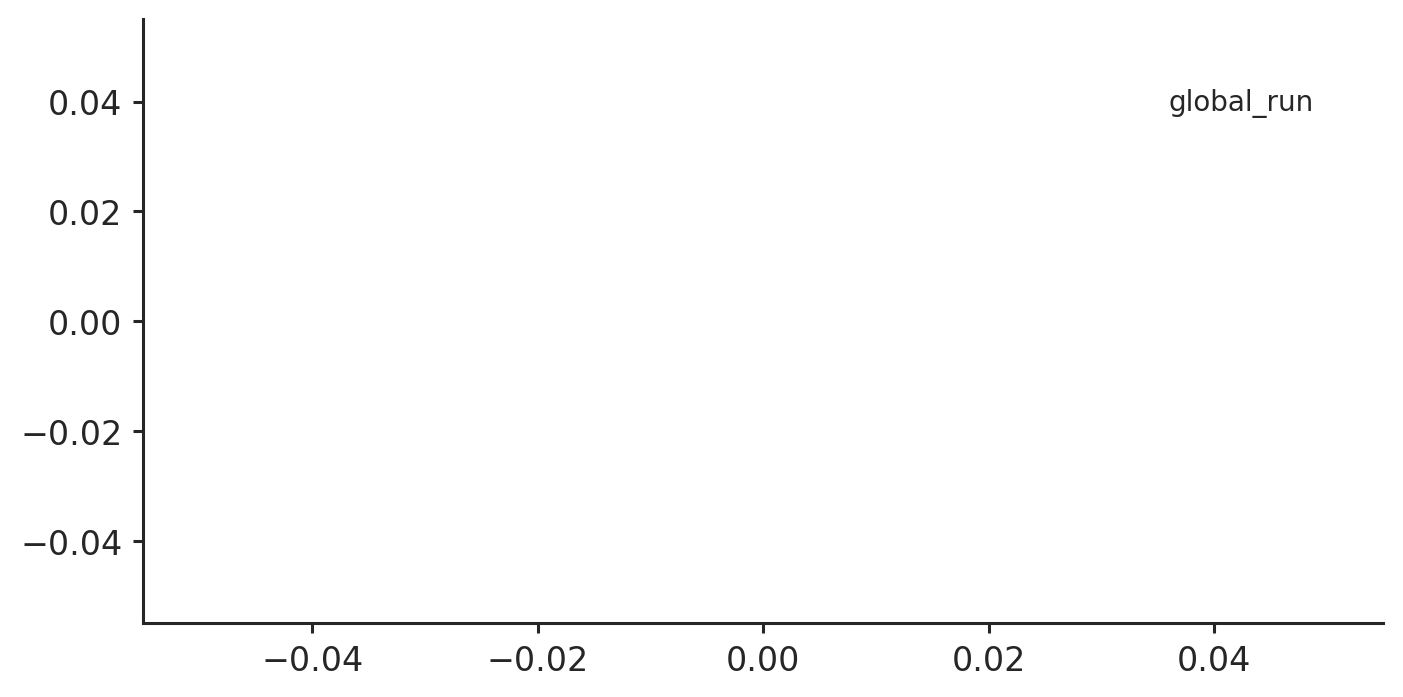

In [66]:
optim_plot(global_run=isres_run_res)

## Large Exploratory Multistart Local Runs

In [262]:

# this wraps the nloptimization call
def nlopt_worker(x, nt, nf):
    nparams = nt*nf + 2
    opt = nlopt.opt(nlopt.LN_COBYLA, nparams)
    #opt = nlopt.opt(nlopt.AUGLAG, nparams)
    #opt.set_local_optimizer(nlopt.LN_COBYLA)
    nll = negll_nlopt(Y, Bp, w)
    opt.set_min_objective(nll) 
    hl, hu = inequality_constraint_functions(nt, nf)
    tols = np.repeat(1e-11, nf)
    opt.add_inequality_mconstraint(hl, tols)
    opt.add_inequality_mconstraint(hu, tols)
    ce = equality_constraint_function(nt, nf)
    opt.add_equality_mconstraint(ce, tols)
    lb, ub = bounds_simplex(nt, nf)
    opt.set_lower_bounds(lb)
    opt.set_upper_bounds(ub)
    #opt.set_xtol_abs(np.array([1e-4, 1e-17] + [1e-6] * nt*nf))
    opt.set_xtol_rel(1e-1)
    #opt.set_ftol_abs(1e-8)
    opt.set_maxeval(100000)
    assert x.size == nparams
    mle = opt.optimize(x)
    nll = opt.last_optimum_value()
    success = opt.last_optimize_result()
    return nll, mle, success

In [ ]:
%%time
N = 1_000_000

#def best(theta):
#    return theta

np.random.seed(1)
worker = partial(nlopt_worker, nt=nt, nf=nf) 
#global_run_res = run_nloptims(worker, partial(best, theta=best_theta), N)
global_run_res = run_nloptims(worker, partial(random_start_simplex, nt=nt, nf=nf), N)

  5%|███████████▏                                                                                                                                                                                                                     | 49919/1000000 [13:45<4:50:07, 54.58it/s]

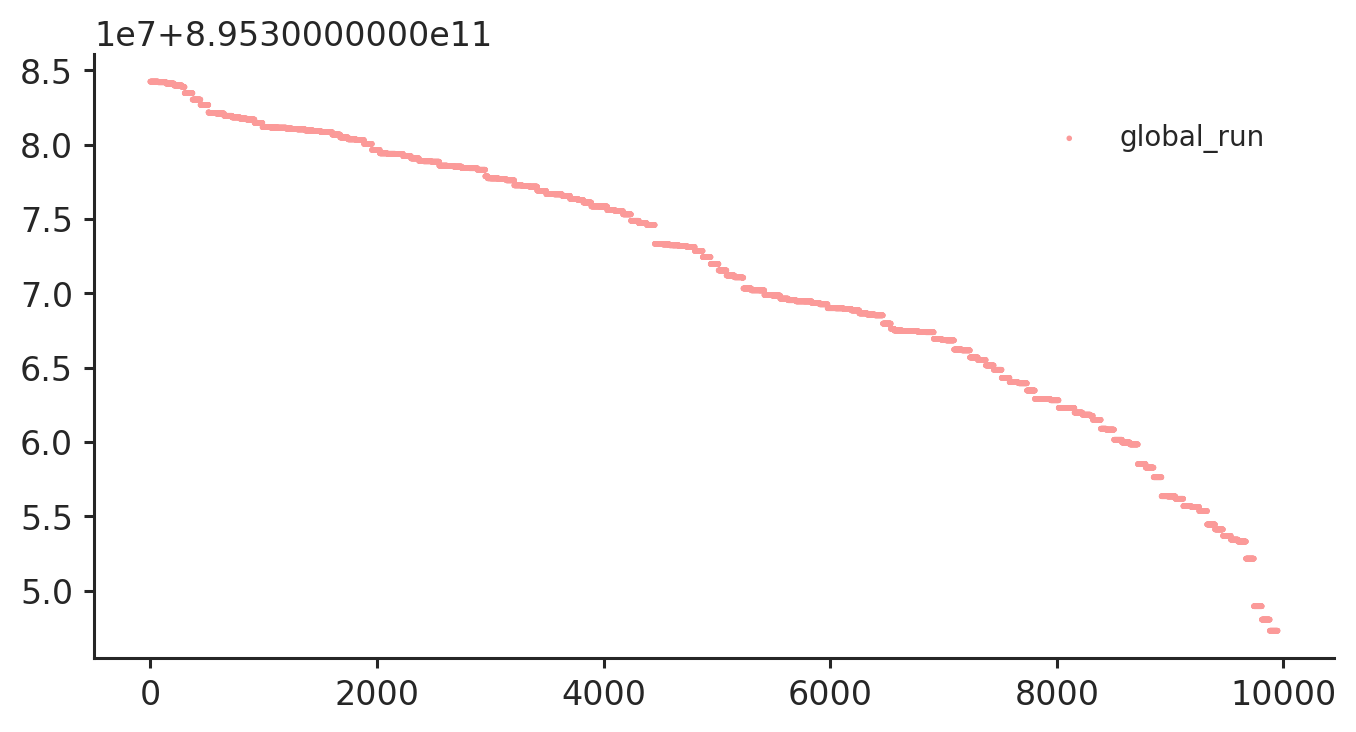

In [259]:
optim_plot(global_run=global_run_res, tail=0.01)

In [260]:
best_theta = nloptim_summary(global_run_res, nt, nf, 0)

exist status stats: xtol reached = 100.0%,max eval = 0.0%
exists: 
NLL: 895347313187.0375
pi0: 0.0018184636238929204

μ: 4.268787038295489e-09
W = 
-----  -----  -----
0.015  0.804  0.346
0.057  0.072  0.073
0.05   0.002  0.026
0.019  0.046  0.321
0.859  0.078  0.233
-----  -----  -----
sums: [1.         1.00248689 1.        ]


## Fixing Mutation Rate

In [320]:
constraint_matrix_fixedmu(nt, nf)[1, 1:].reshape((nt, nf))

array([[0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.],
       [0., 1., 0.]])

In [321]:
def constraint_matrix_fixedmu(nt, nf):
    nparams = nt*nf + 1
    A = np.zeros((nf, nparams))
    for i in range(nf):
        W = A[i, 1:].reshape((nt, nf))
        W[:, i] = 1.
    return A

def inequality_constraint_functions_fixedmu(nt, nf, mu):
    """
     l < μ W < u
     l - μ W < 0
     μ W - u < 0
    """
    A = constraint_matrix_fixedmu(nt, nf)
    lower = 0
    upper = 1
    def func_l(result, x, grad):
        M = lower - (mu *  A.dot(x))
        for i in range(nf):
            result[i] = M[i]
    def func_u(result, x, grad):
        M = (mu *  A.dot(x)) - upper
        for i in range(nf):
            result[i] = M[i]
    return func_l, func_u

def equality_constraint_function_fixedmu(nt, nf):
    A = constraint_matrix_fixedmu(nt, nf)
    def func(result, x, grad):
        M = A.dot(x)
        for i in range(nf):
            result[i] = M[i] - 1.
    return func


def negll_fixedmu_nlopt(Y, B, w, mu):
    # NLOPT needs to accept a grad argument
    def func(x, grad):
        theta = np.empty(x.size + 1)
        theta[0] = x[0]
        theta[1] = mu
        theta[2:] = x[1:].flat
        return negll_c(theta, Y, B, w)
    return func

def bounds_simplex_fixedmu(nt, nf, log10_pi0_bounds=(-4, -2),
           paired=False):
    l = [10**log10_pi0_bounds[0]]
    u = [10**log10_pi0_bounds[1]]
    l += [0.]*nf*nt
    u += [1.]*nf*nt
    lb = np.array(l)
    ub = np.array(u)
    assert np.all(lb < ub)
    if paired:
        return list(zip(lb, ub))
    return lb, ub


def nlopt_fixedmu_worker(x, nt, nf, mu):
    nparams = nt*nf + 1
    opt = nlopt.opt(nlopt.LN_COBYLA, nparams)
    #opt = nlopt.opt(nlopt.AUGLAG, nparams)
    #opt.set_local_optimizer(nlopt.LN_COBYLA)
    nll = negll_fixedmu_nlopt(Y, Bp, w, mu)
    opt.set_min_objective(nll) 
    hl, hu = inequality_constraint_functions_fixedmu(nt, nf, mu)
    tols = np.repeat(1e-11, nf)
    opt.add_inequality_mconstraint(hl, tols)
    opt.add_inequality_mconstraint(hu, tols)
    ce = equality_constraint_function_fixedmu(nt, nf)
    opt.add_equality_mconstraint(ce, tols)
    lb, ub = bounds_simplex_fixedmu(nt, nf)
    opt.set_lower_bounds(lb)
    opt.set_upper_bounds(ub)
    #opt.set_xtol_abs(np.array([1e-4, 1e-17] + [1e-6] * nt*nf))
    opt.set_xtol_rel(1e-1)
    #opt.set_ftol_abs(1e-8)
    opt.set_maxeval(100000)
    assert x.size == nparams
    mle = opt.optimize(x)
    nll = opt.last_optimum_value()
    success = opt.last_optimize_result()
    return nll, mle, success

def random_start_simplex_fixedmu(nt, nf, log10_pi0_bounds=(-4, -3)):
    pi0 = 10**np.random.uniform(log10_pi0_bounds[0], log10_pi0_bounds[1], 1)
    W = np.empty((nt, nf))
    for i in range(nf):
        W[:, i] = np.random.dirichlet([1.] * nt)
        assert np.abs(W[:, i].sum() - 1.) < 1e-5
    theta = np.empty(nt*nf + 1)
    theta[0] = pi0
    theta[1:] = W.flat
    return theta

In [326]:
%%time
N = 10_000

np.random.seed(1)
worker = partial(nlopt_fixedmu_worker, nt=nt, nf=nf, mu=1e-8) 
fixedmu_run_res = run_nloptims(worker, partial(random_start_simplex_fixedmu, nt=nt, nf=nf), N)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [13:02<00:00, 12.78it/s]


CPU times: user 23.5 s, sys: 10.5 s, total: 34 s
Wall time: 13min 5s


In [328]:
nloptim_summary(fixedmu_run_res, nt, nf, 0)

True 16
exist status stats: xtol reached = 99.0%,max eval = 1.0%
exists: 
NLL: 895357195700.012
pi0: 0.0018868585800278235

μ: --fixed?--
W = 
-----  -----  -----
0.473  0.997  0.976
0      0      0.002
0.01   0      0.004
0.011  0.003  0.005
0.507  0.008  0.019
-----  -----  -----
sums: [1.         1.00815078 1.00606131]


array([1.88685858e-03, 4.72654103e-01, 9.96772602e-01, 9.76072267e-01,
       1.32785735e-18, 1.17138320e-16, 1.67017798e-03, 1.02644437e-02,
       8.02929467e-05, 4.39113673e-03, 1.05282096e-02, 3.22739774e-03,
       5.23682672e-03, 5.06553243e-01, 8.07048626e-03, 1.86909067e-02])

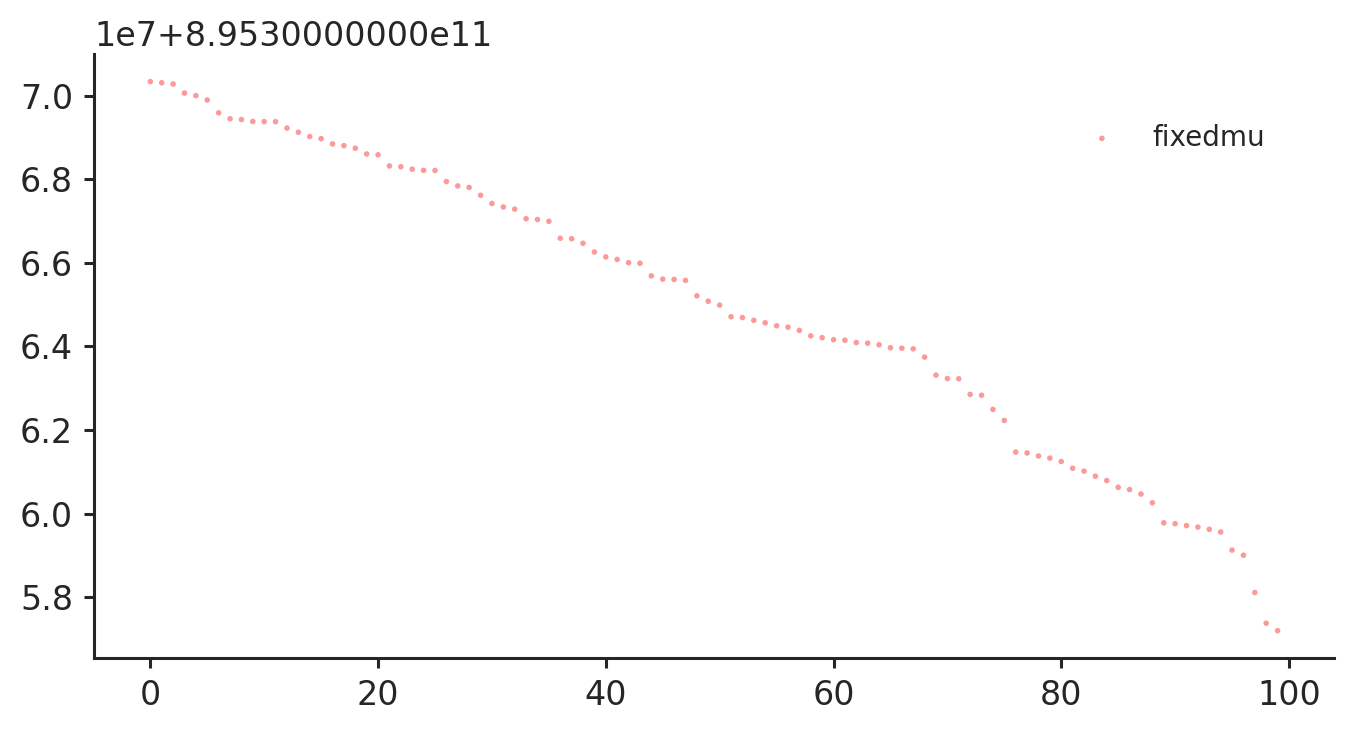

In [329]:
optim_plot(fixedmu=fixedmu_run_res, tail=0.01)

(array([3053., 1077., 1120., 1301., 1052., 1057.,  953.,  154.,   93.,
         140.]),
 array([1.00000000e-11, 7.22542722e-10, 1.43508544e-09, 2.14762817e-09,
        2.86017089e-09, 3.57271361e-09, 4.28525633e-09, 4.99779906e-09,
        5.71034178e-09, 6.42288450e-09, 7.13542722e-09]),
 <BarContainer object of 10 artists>)

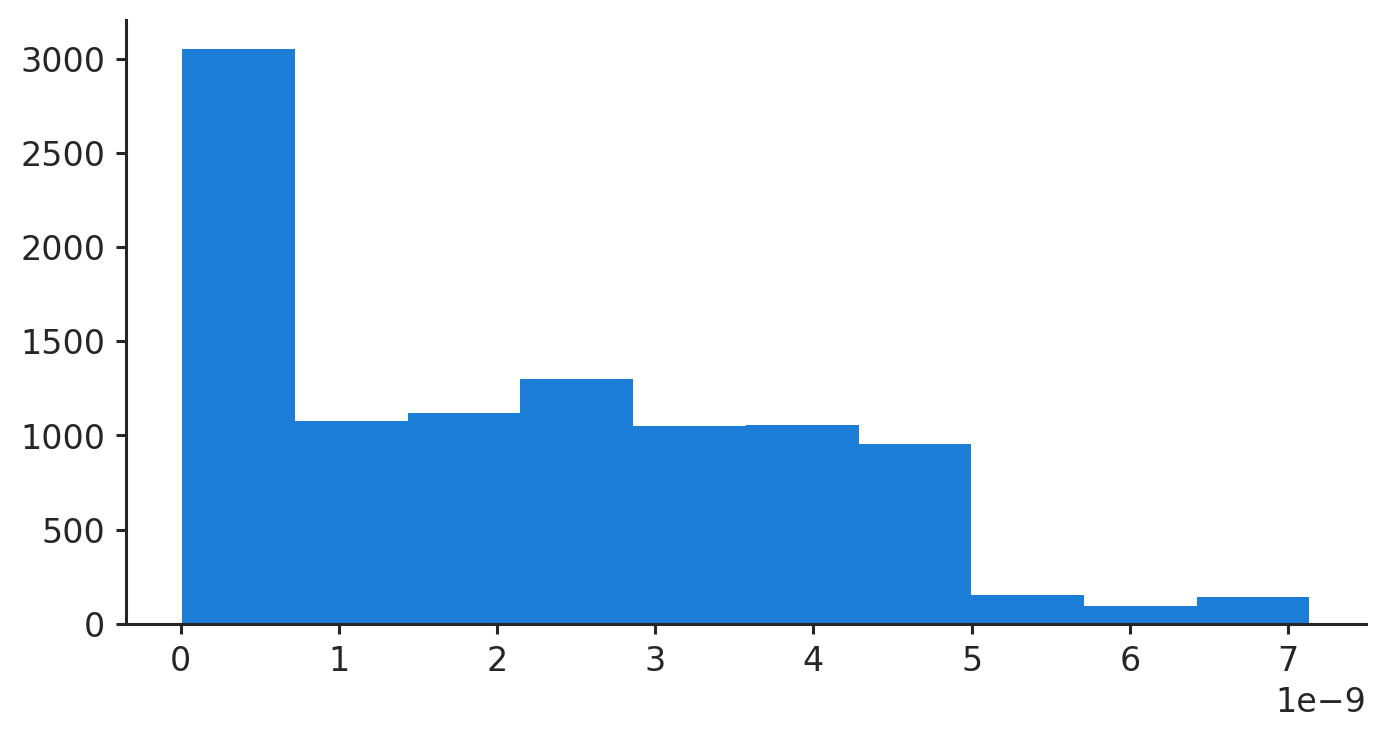

In [30]:
plt.hist(global_run_res[1][np.argsort(global_run_res[0])[:10000]][:, 1])

In [100]:
best = thetas[np.aargsort(nlls)[200]]

N = 5_000_000

#np.random.seed(1)
worker = partial(nlopt_worker, nt=nt, nf=nf) 
global_run_res = run_nloptims(worker, partial(random_start_simplex, nt=nt, nf=nf), N)

array([1.91680094e-03, 1.07420160e-08, 5.76604507e-01, 7.28639346e-01,
       5.41392344e-01, 5.12551692e-02, 6.58909005e-02, 8.63348104e-02,
       4.60563151e-03, 8.22124645e-04, 8.61878601e-04, 1.31536886e-02,
       7.05730961e-02, 9.67865180e-04, 3.54381003e-01, 1.34074533e-01,
       3.70443101e-01])

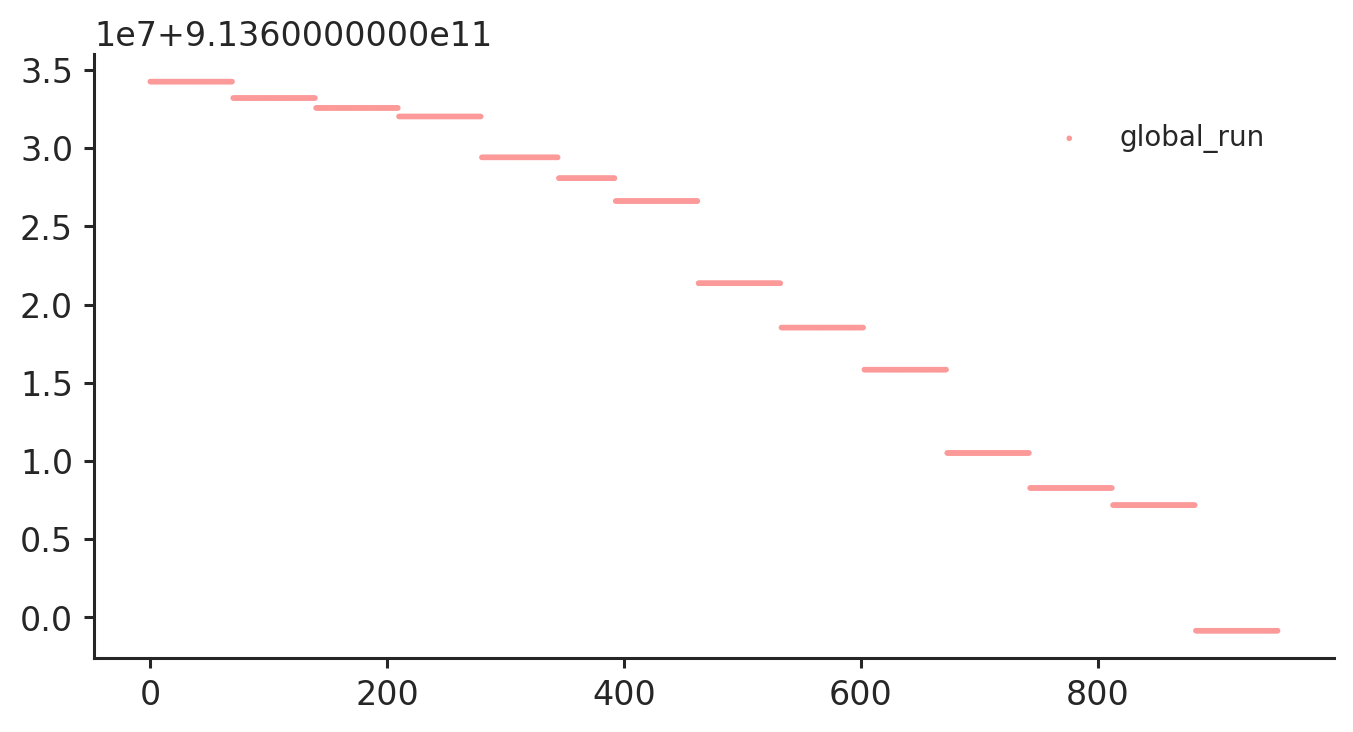

In [104]:
optim_plot(global_run=global_run_res, tail=0.001)

In [171]:
best_theta = nloptim_summary(global_run_res, nt, nf) # 3rd run

NLL: 913599145884.1907
pi0: 0.0018253262059501308

μ: 4.564287647326172e-09
W = 
-----  -----  -----
0.133  0.272  0.506
0.109  0.013  0.289
0.002  0.27   0.002
0.112  0.134  0.137
0.644  0.311  0.067
-----  -----  -----
sums: [1. 1. 1.]


In [105]:
best_theta = nloptim_summary(global_run_res, nt, nf) # 2nd run

NLL: 913599145884.1907
pi0: 0.0018253262059501308

μ: 4.564287647326172e-09
W = 
-----  -----  -----
0.133  0.272  0.506
0.109  0.013  0.289
0.002  0.27   0.002
0.112  0.134  0.137
0.644  0.311  0.067
-----  -----  -----
sums: [1. 1. 1.]


In [401]:
best_theta = nloptim_summary(global_run_res, nt, nf) # first run

NLL: 913570926435.8547
pi0: 0.00195829561471389

μ: 1.232386727173979e-08
W = 
-----  -----  -----
0.574  0.751  0.906
0.002  0.098  0.074
0.044  0.029  0.001
0      0.011  0.012
0.381  0.11   0.008
-----  -----  -----
sums: [1.00161235 1.         1.        ]


In [438]:
bt = np.array([0.00195829561471389, 1.232386727173979e-08, 0.574 , 0.751,  0.906,
          0.002 , 0.098,  0.074, 0.044,  0.029,  0.001, 0   ,   0.011 , 0.012,
          0.381,  0.11,   0.008])
          

### Experimental Perturbation Starts

It could be an issue of choosing the right perturbation scale, but this looked like it didn't work. I think that this is more becausing finding the true MLE in this space is hard — there are lots of local optima that need to be explored.

In [381]:
def trunc_normal(loc, scale, lower, upper):
    a, b = (lower - loc) / scale, (upper - loc) / scale
    return np.random.normal(loc, scale)
    return truncnorm.rvs(a, b)

def perturber(theta, log10_pi0_bounds=(-4, -3),
            log10_mu_bounds=(-11, -7), pi0_scale=1e-6, 
            mu_scale=1e-12, dfe_scale=1e-04):
    def func():
        new_theta = np.copy(theta)
        normal = truncnorm.rvs

        new_theta[0] = trunc_normal(theta[0], pi0_scale, 10**log10_pi0_bounds[0], 10**log10_pi0_bounds[1])
        new_theta[1] = trunc_normal(theta[1], mu_scale, 10**log10_mu_bounds[0], 10**log10_mu_bounds[1])
        for i in range(2, theta.size):
            w = theta[i]
            new_theta[i] = trunc_normal(w, dfe_scale, 10**log10_mu_bounds[0]/w, 10**log10_mu_bounds[1]/w)
        return new_theta
    return func

In [382]:
perturb_starts = perturber(best_theta)
run_res = run_nloptims(worker, perturb_starts, 4000)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4000/4000 [00:30<00:00, 130.74it/s]


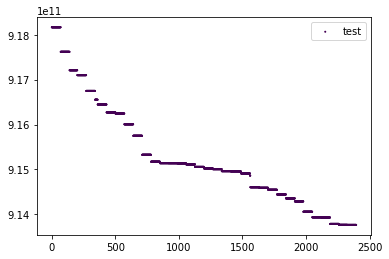

In [383]:
optim_plot(test=run_res, tail=0.6)

## Penalized Methods

Some of the instability of convergence to the optimum is that the model cannot choose between weak or strong mutation (and visa versa for selection). 

We could put a prior on this mutation rate, since we have many other estimates. A recent paper (Tian, Browning, and Browning, 2019) estimated the mutation rate as $\mu = 1.28 \times 10^{-8}$ ($95\%$ CI, $1.02 \times 10^{-8}, 1.56 \times 10^{-8}$).

In [132]:
sigma

6.581753637311707e-09

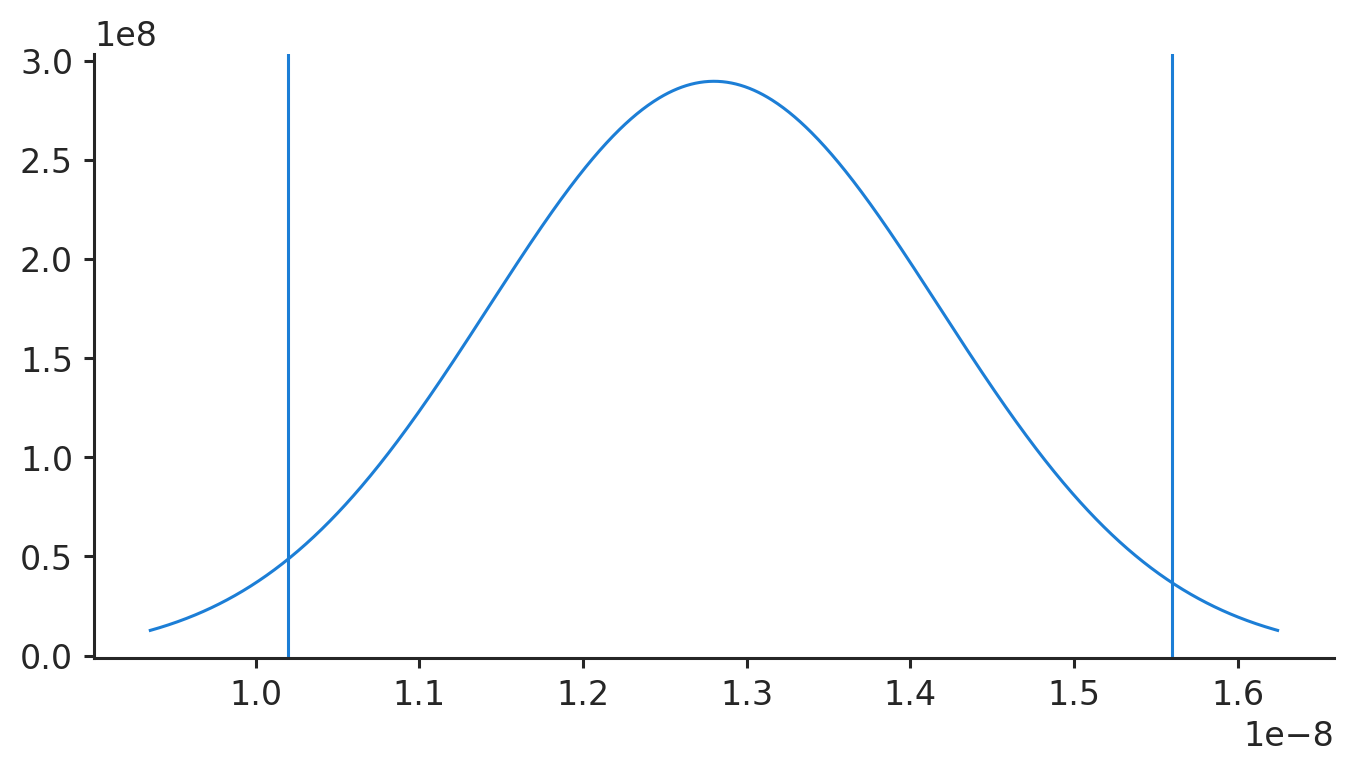

In [169]:
mean = 1.28e-8
ci = [1.02e-8, 1.56e-8]

def ci2params(mean, ci, alpha=0.05):
    crit = stats.norm.ppf(1 - alpha/2)
    sigma1 = (mean-ci[0])/crit
    sigma2 = (ci[1]-mean)/crit
    return mean, np.mean((sigma1, sigma2))

mean, sigma = ci2params(mean, ci)

z = np.linspace(mean - 2.5*sigma, mean + 2.5*sigma, 1000)
y = stats.norm(mean, sigma).pdf(z)
plt.plot(z, y)
#plt.hist(stats.norm(mean, sigma).rvs(10000), 100, density=True)
#plt.axvline(mean -sigma)
plt.axvline(ci[0])
plt.axvline(ci[1])

In [179]:
r = 1/(sigma / 1e3)**2

r, -r * (mean - 4.6e-9)**2 / 2 / 1e11

(5.26949083771485e+23, -0.00017716028196397327)

In [159]:
(mean - 4.6e-9)**2

6.724000000000001e-17

In [182]:
negll_c(best_theta, Y, B, w), penalized_negll_c(best_theta, Y, B, w, 1.23e-8, r = r)

(947520298534.3077, 947536065179.079)

In [15]:
def penalized_negll_nlopt(Y, B, w, mu0, r):
    # NLOPT needs to accept a grad argument
    def func(x, grad):
        return penalized_negll_c(x, Y, B, w, mu0, r)
    return func


def penalized_nlopt_worker(start, nt, nf, mu0, r):
    nparams = nt*nf + 2
    opt = nlopt.opt(nlopt.LN_COBYLA, nparams)
    #opt = nlopt.opt(nlopt.LN_BOBYQA, nparams)    
    #opt = nlopt.opt(nlopt.AUGLAG, nparams)
    #opt.set_local_optimizer(nlopt.LN_COBYLA)
    nll = penalized_negll_nlopt(Y, Bp, w, mu0=mu0, r=r)
    opt.set_min_objective(nll) 
    hl, hu = inequality_constraint_functions(nt, nf)
    tols = np.repeat(1e-11, nf)
    opt.add_inequality_mconstraint(hl, tols)
    opt.add_inequality_mconstraint(hu, tols)
    ce = equality_constraint_function(nt, nf)
    opt.add_equality_mconstraint(ce, tols)
    lb, ub = bounds_simplex(nt, nf)
    opt.set_lower_bounds(lb)
    opt.set_upper_bounds(ub)
    opt.set_xtol_abs(np.array([1e-4, 1e-10] + [1e-4] * nt*nf))
    #opt.set_ftol_abs(1e8)
    #opt.set_stopval(923543002497)
    opt.set_maxeval(100000)
    x = random_start_simplex(nt, nf)
    assert x.size == nparams
    mle = opt.optimize(x)
    nll = opt.last_optimum_value()
    success = opt.last_optimize_result()
    return nll, mle, success

N = 10_000

np.random.seed(1)
worker = partial(penalized_nlopt_worker, nt=nt, nf=nf, mu0=1.23e-8, r=0) 
#penalized_run_res = run_nloptims(worker, partial(random_start_simplex, nt=nt, nf=nf), N)

In [16]:
worker(random_start_simplex(nt, nf))

(914961679993.7748,
 array([1.39679203e-03, 4.94702729e-11, 4.95901052e-02, 5.22419431e-01,
        4.46893191e-01, 2.51695287e-01, 4.22392500e-01, 1.29091904e-02,
        4.48185890e-01, 2.00591742e-02, 1.99485657e-02, 6.38105712e-02,
        1.37403379e-02, 5.10911071e-01, 1.86718146e-01, 2.13885574e-02,
        9.33798272e-03]),
 4)

In [50]:
nloptim_summary(penalized_run_res, nt, nf)

convergence: 100.0%
NLL: 984960361922.2891
pi0: 0.00036198437813619026

μ: 3.643743139281255e-11
W = 
-----  -----  -----
0.032  0.449  0.315
0.236  0.483  0.015
0.504  0.019  0.082
0.055  0.009  0.474
0.172  0.04   0.114
-----  -----  -----
sums: [1. 1. 1.]


array([3.61984378e-04, 3.64374314e-11, 3.22819303e-02, 4.49062399e-01,
       3.14902251e-01, 2.35880812e-01, 4.83309711e-01, 1.54878234e-02,
       5.04499560e-01, 1.90912333e-02, 8.17794257e-02, 5.49851657e-02,
       8.55713568e-03, 4.73865038e-01, 1.72352532e-01, 3.99795219e-02,
       1.13965462e-01])

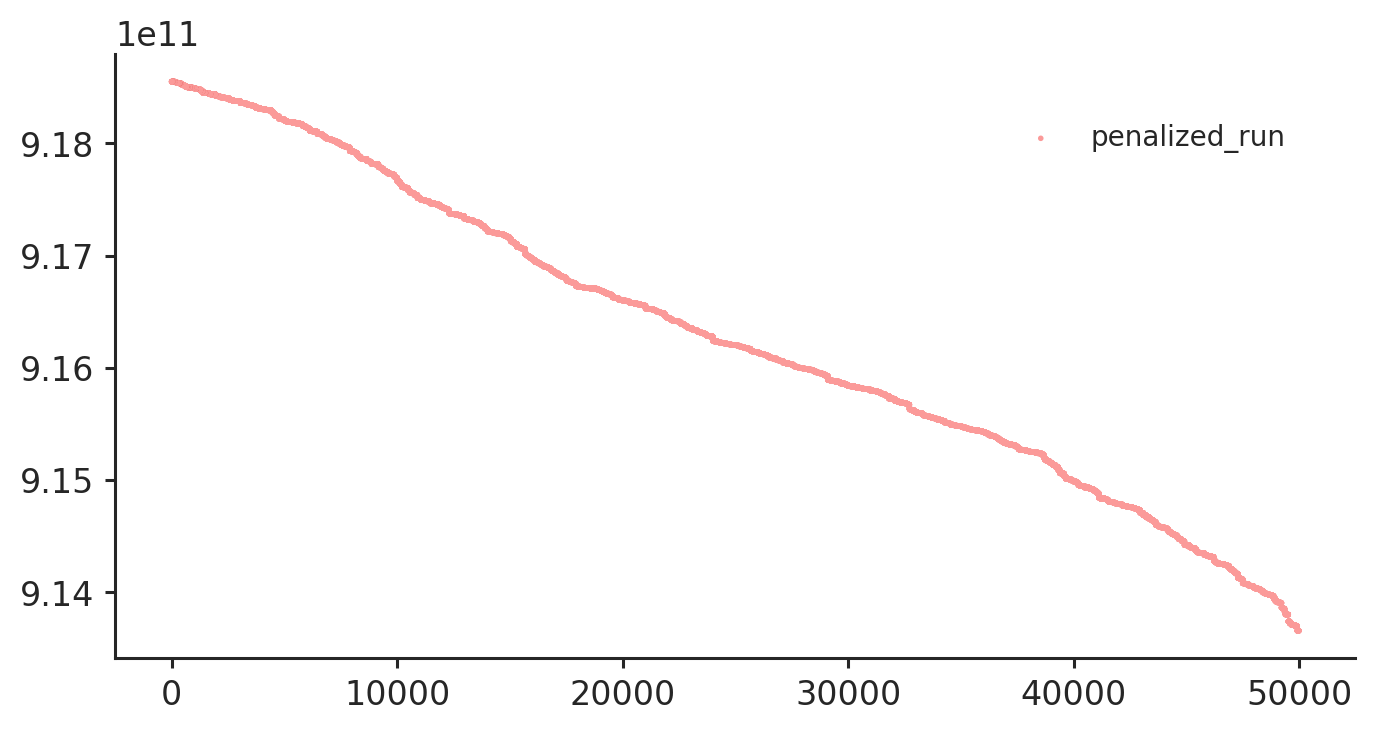

In [12]:
optim_plot(penalized_run=penalized_run_res)

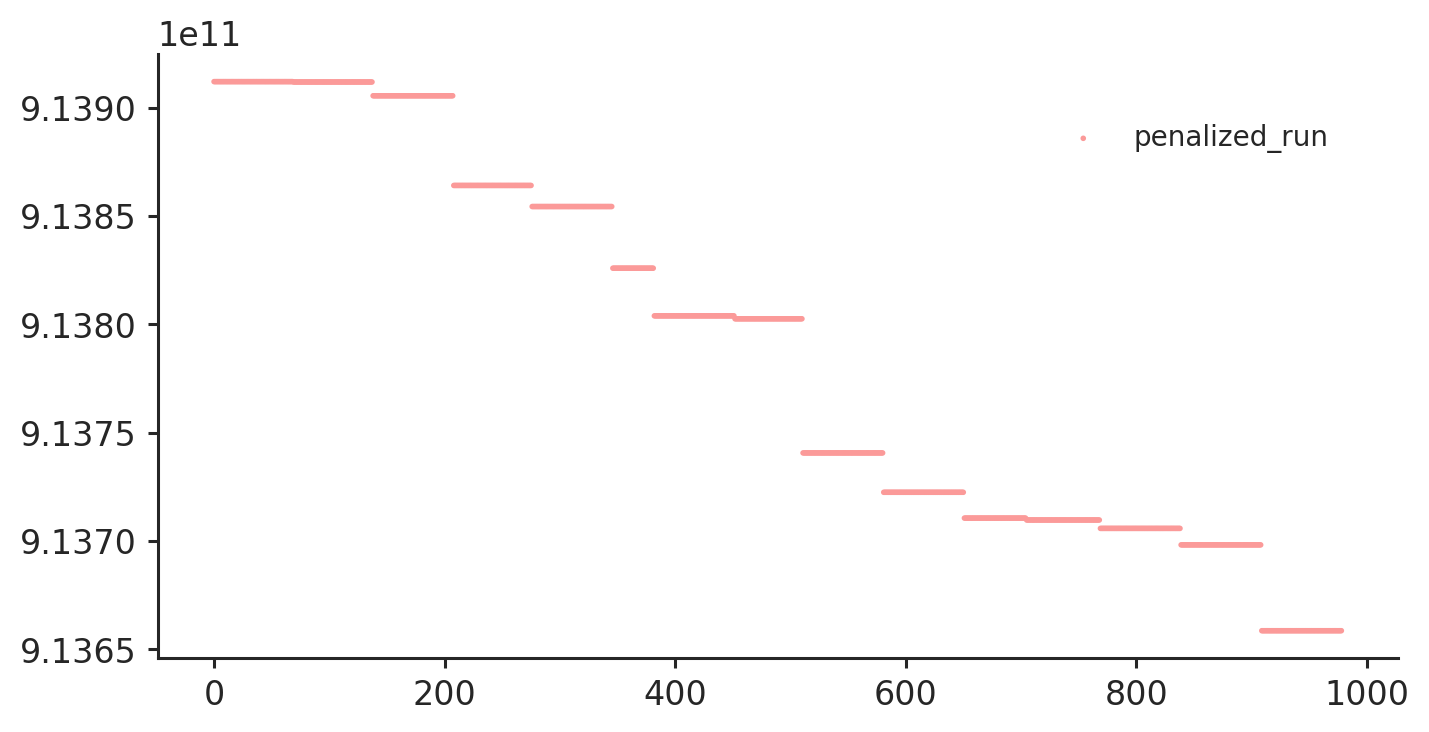

In [13]:
optim_plot(penalized_run=penalized_run_res, tail=0.01)

In [14]:
pbr = nloptim_summary(penalized_run_res, nt, nf)

convergence: 100.0%
NLL: 913658631007.3448
pi0: 0.0018492123626910018

μ: 1.2736366827062304e-08
W = 
-----  -----  -----
0.828  0.151  0.855
0.01   0.003  0.08
0.027  0.008  0.007
0.043  0.322  0.004
0.092  0.519  0.055
-----  -----  -----
sums: [1.         1.00309528 1.        ]


In [508]:
pbr = nloptim_summary(penalized_run_res, nt, nf)

convergence: 100.0%
NLL: 913658631007.3448
pi0: 0.0018492123626910018

μ: 1.2736366827062304e-08
W = 
-----  -----  -----
0.828  0.151  0.855
0.01   0.003  0.08
0.027  0.008  0.007
0.043  0.322  0.004
0.092  0.519  0.055
-----  -----  -----
sums: [1.         1.00309528 1.        ]


In [211]:
nloptim_summary(penalized_run_res, nt, nf)

convergence: 100.0%
NLL: 913680208619.4436
pi0: 0.0018699516414047003

μ: 1.2283691105884408e-08
W = 
-----  -----  -----
0.627  0.783  0.752
0.003  0.049  0.034
0      0      0.002
0.017  0.005  0.114
0.37   0.169  0.098
-----  -----  -----
sums: [1.0174961  1.00497626 1.        ]


array([1.86995164e-03, 1.22836911e-08, 6.27148238e-01, 7.82564706e-01,
       7.52499820e-01, 2.59237925e-03, 4.87227843e-02, 3.37434369e-02,
       4.62728495e-17, 2.31364247e-17, 2.20313237e-03, 1.74961007e-02,
       4.97626084e-03, 1.13611051e-01, 3.70259383e-01, 1.68712510e-01,
       9.79425599e-02])

## LIPO Optimization

In [216]:
from lipo import GlobalOptimizer

In [238]:
params = ['pi0'] + [f"w{i}" for i in range(nt*nf)]

In [239]:
glb, gub = [dict(zip(params, x.tolist())) for x in bounds_mutation(nf, nt)]

In [264]:
glb

{'pi0': 0.0001,
 'w0': 1e-11,
 'w1': 1e-11,
 'w2': 1e-11,
 'w3': 1e-11,
 'w4': 1e-11,
 'w5': 1e-11,
 'w6': 1e-11,
 'w7': 1e-11,
 'w8': 1e-11,
 'w9': 1e-11,
 'w10': 1e-11,
 'w11': 1e-11,
 'w12': 1e-11,
 'w13': 1e-11,
 'w14': 1e-11}

In [265]:
for l in [f"w{i}" for i in range(nt*nf)]:
    print(l + ", ", end='')

w0, w1, w2, w3, w4, w5, w6, w7, w8, w9, w10, w11, w12, w13, w14, 

In [270]:
def negll_freemut_alt(Y, B, w):
    def func(pi0, w0, w1, w2, w3, w4, w5, w6, w7, w8, w9, w10, w11, w12, w13, w14):
        new_theta = np.zeros(17)
        new_theta[0] = pi0
        # fix mutation rate to one and let W represent mutation rates to various classes
        new_theta[1] = 1.
        new_theta[2:] = [w0, w1, w2, w3, w4, w5, w6, w7, w8, w9, w10, w11, w12, w13, w14] # times mutation rates        
        return negll_c(new_theta, Y, B, w)
    return func

nllBp = negll_freemut_alt(Y, Bp, w)
nllB = negll_freemut_alt(Y, B, w)

In [273]:
evaluations

[({'pi0': 0.00012569710220299894,
   'w0': 5.184542412758666e-10,
   'w1': 2.0984661616025693e-09,
   'w2': 1.181035917241304e-08,
   'w3': 5.184542412758666e-10,
   'w4': 2.0984661616025693e-09,
   'w5': 1.181035917241304e-08,
   'w6': 5.184542412758666e-10,
   'w7': 2.0984661616025693e-09,
   'w8': 1.181035917241304e-08,
   'w9': 5.184542412758666e-10,
   'w10': 2.0984661616025693e-09,
   'w11': 1.181035917241304e-08,
   'w12': 5.184542412758666e-10,
   'w13': 2.0984661616025693e-09,
   'w14': 1.181035917241304e-08},
  1188291215969.2021)]

In [ ]:
pre_eval_x = dict(zip(params, random_start_mutation(nt, nf).tolist()))
evaluations = [(pre_eval_x, nllBp(**pre_eval_x))]

search = GlobalOptimizer(
    nllBp,
    lower_bounds=glb,
    upper_bounds=gub,
    #categories={"z": ["a", "b"]},
    evaluations=evaluations,
    maximize=False,
)

num_function_calls = 10000
search.run(num_function_calls)

In [ ]:
search.optimum

## Likelihood Diagnostics

In [31]:
Y

array([[1.02937921e+10, 1.54374130e+07],
       [3.76998984e+10, 6.60935820e+07],
       [3.62663334e+10, 5.02017070e+07],
       ...,
       [4.21851954e+10, 9.44283770e+07],
       [3.35130567e+10, 6.75657360e+07],
       [3.40908069e+10, 5.29977390e+07]])

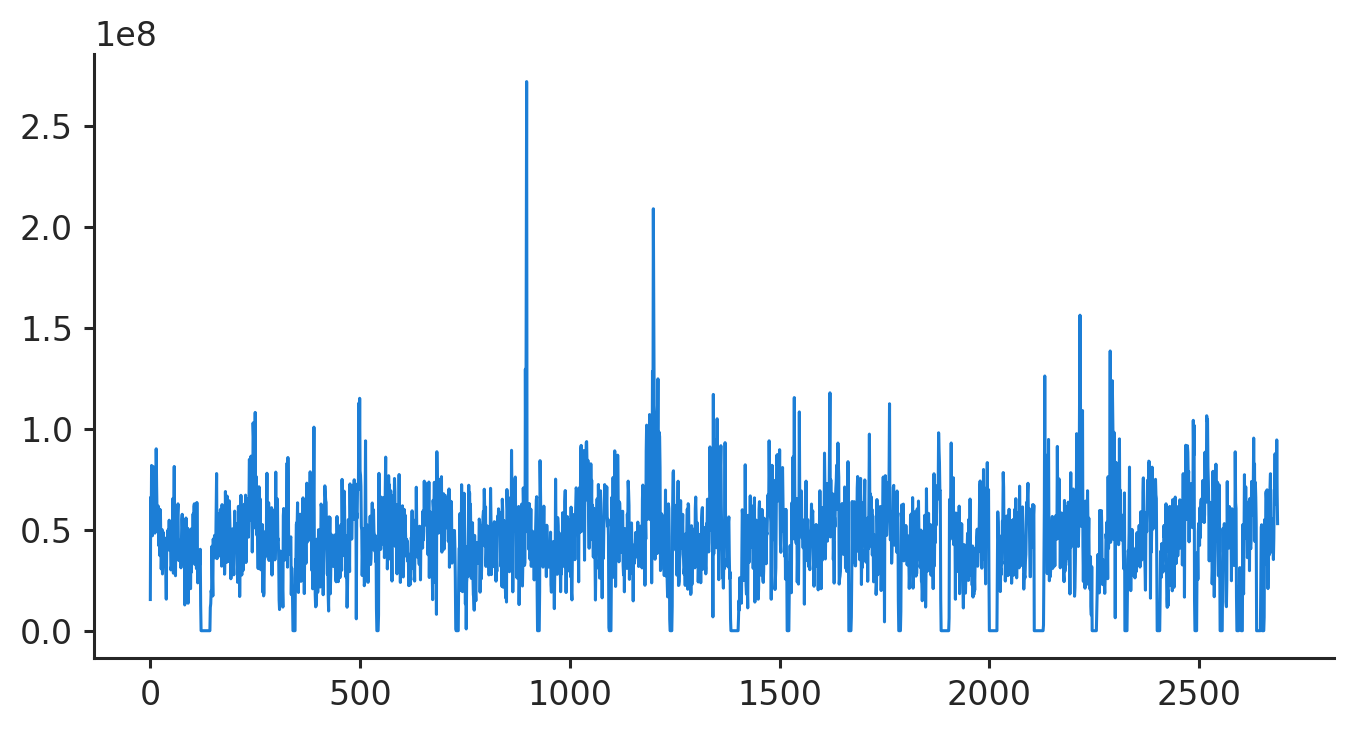

In [32]:
plt.plot(np.arange(Y.shape[0]), Y[:, 1])

/tmp/ipykernel_10842/3200564035.py:6: RuntimeWarning: invalid value encountered in true_divide
  x = Y[:, 0] / (Y.sum(axis=1))


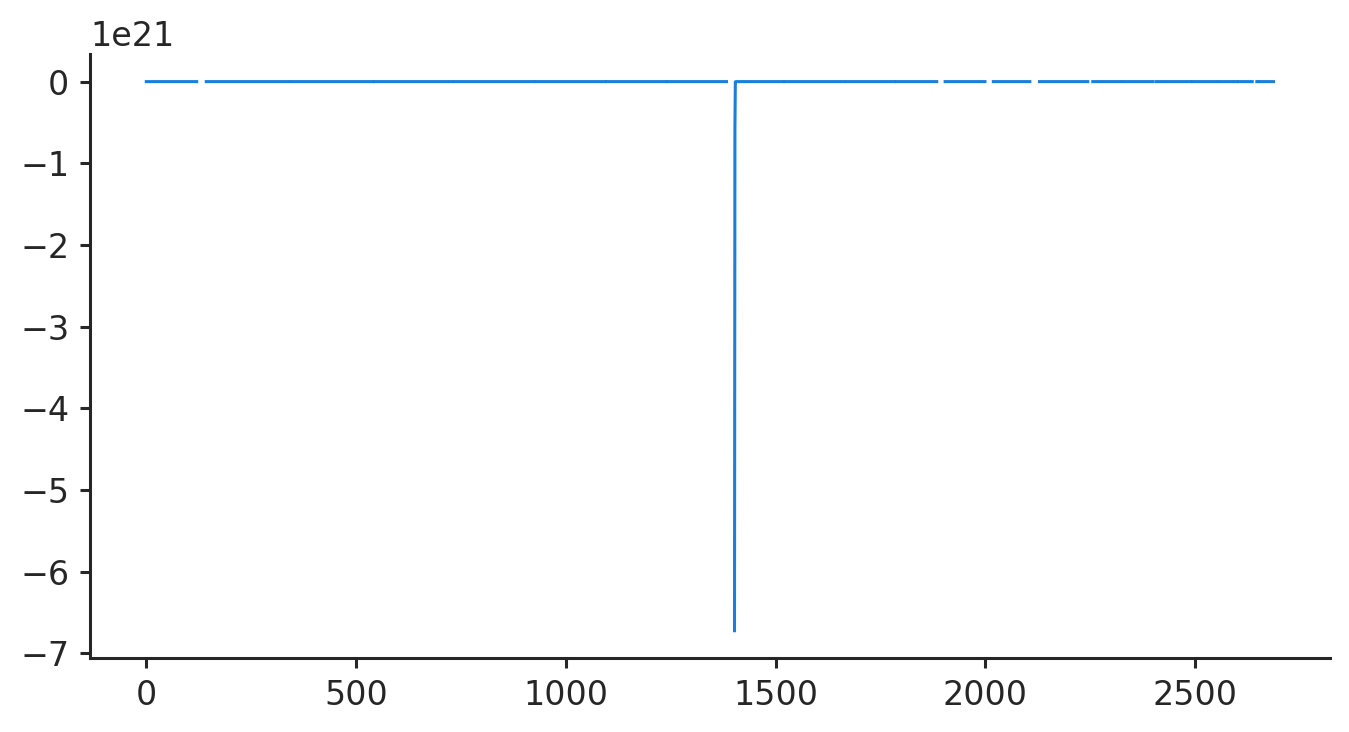

In [35]:
from bgspy.likelihood import predict_simplex
pi = predict_simplex(best_theta, B, w)

N = Y.sum(axis=1)

x = Y[:, 0] / (Y.sum(axis=1))
plt.plot(stats.norm(loc=N*pi, scale=N*pi*(1-pi)).logpdf(x))
#plt.ylim(-0.2e2, 0)

/tmp/ipykernel_10842/3072290513.py:6: RuntimeWarning: invalid value encountered in true_divide
  x = Y[:, 1] / (Y.sum(axis=1))


(-20.0, 0.0)

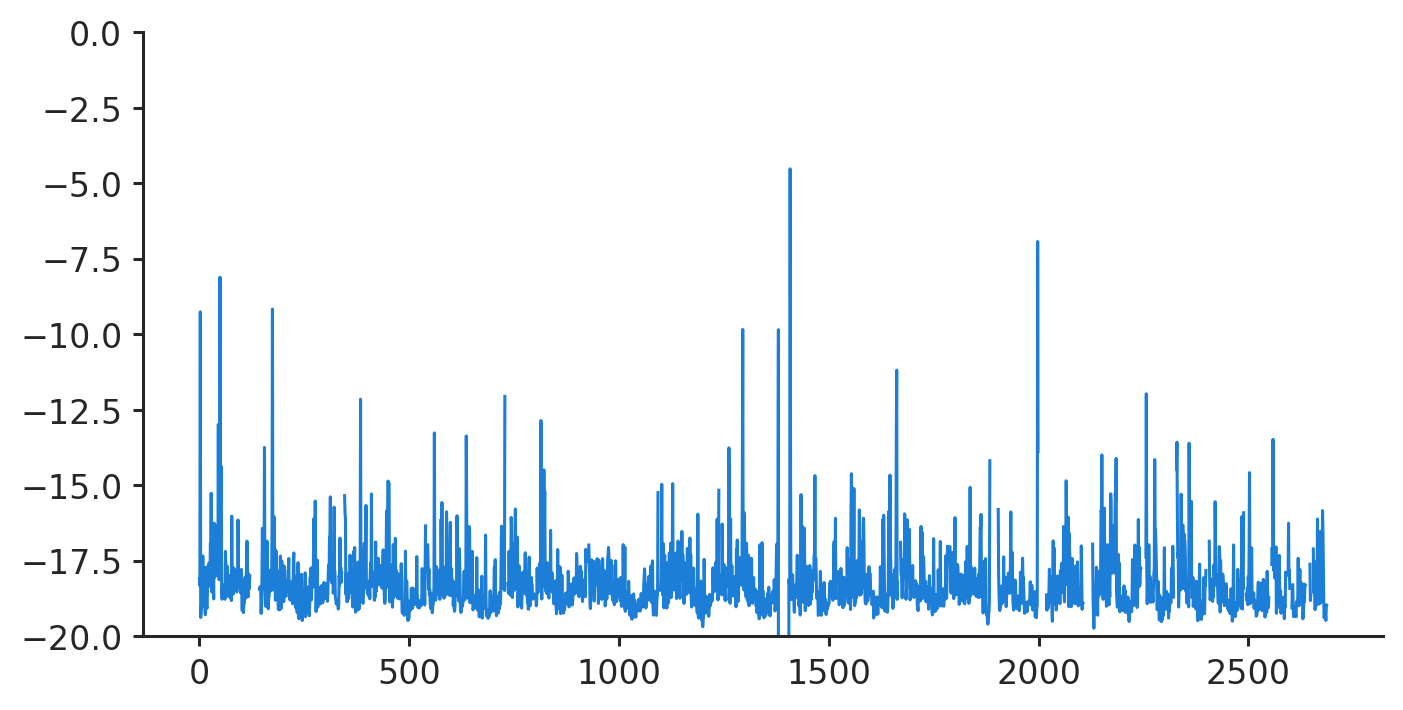

In [63]:
from bgspy.likelihood import predict_simplex
pi = predict_simplex(best_theta, B, w)

N = Y.sum(axis=1)

x = Y[:, 1] / (Y.sum(axis=1))
y = stats.norm(loc=N*pi, scale=N*pi*(1-pi)).logpdf(x)
plt.plot(y)
plt.ylim(-0.2e2, 0)

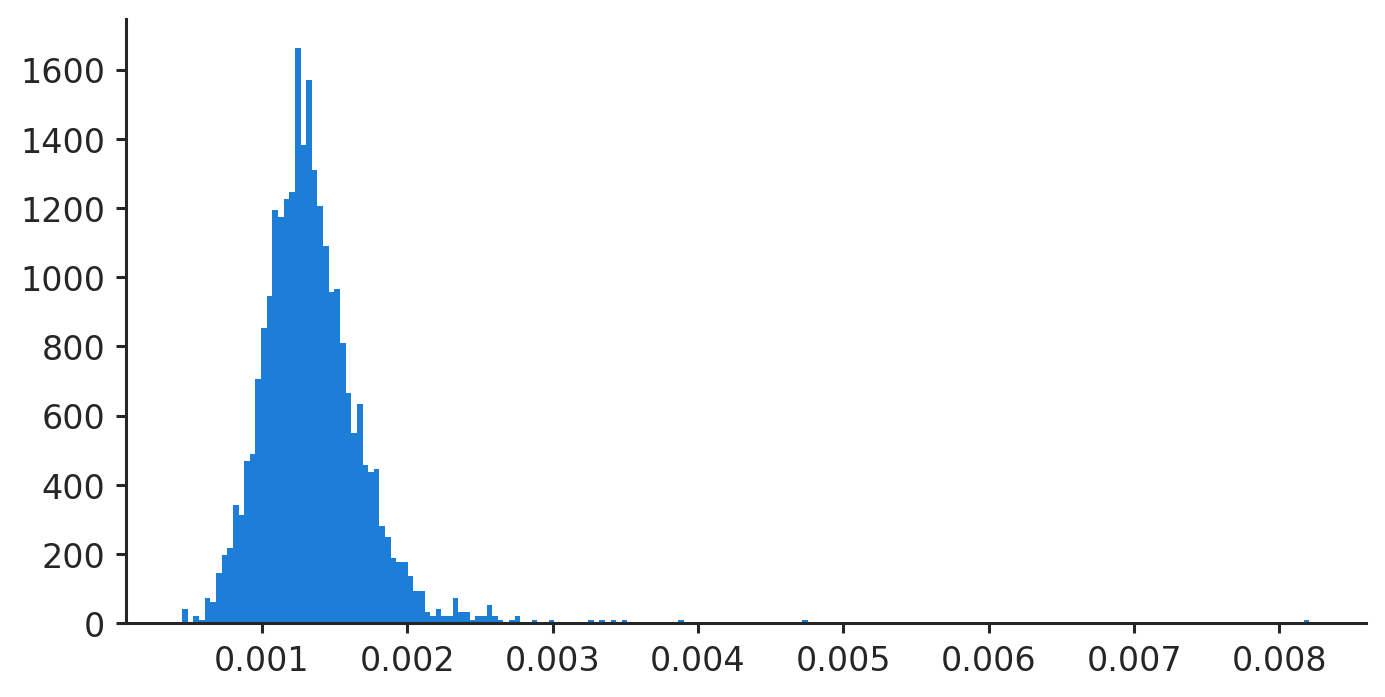

In [66]:
_ = plt.hist(x, 200, density=True)

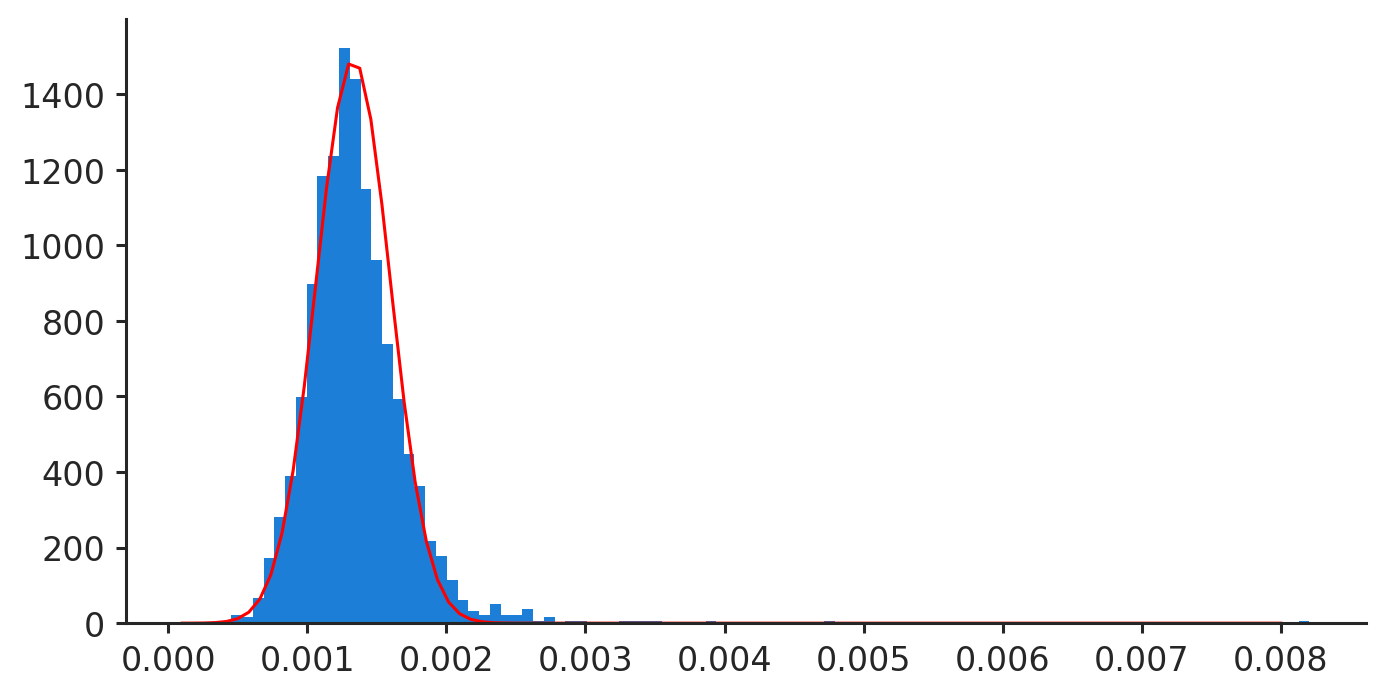

In [106]:
_ = plt.hist(x, 100, density=True)
z = np.linspace(0.0001, 0.008, 100)
# trimmed mean
alpha = 0.05
idx = (np.nanquantile(x, alpha/2) < x) & (np.nanquantile(x, 1-alpha/2) > x)
xt = x[idx]
plt.plot(z, stats.norm(loc=np.nanmean(xt), scale=np.nanstd(xt)).pdf(z), c='r')
plt.plot(z, stats.binom(p=np.nanmean(xt), n=N.mean()).pmf(z), c='g')

In [111]:
N.mean()

33371206913.530132

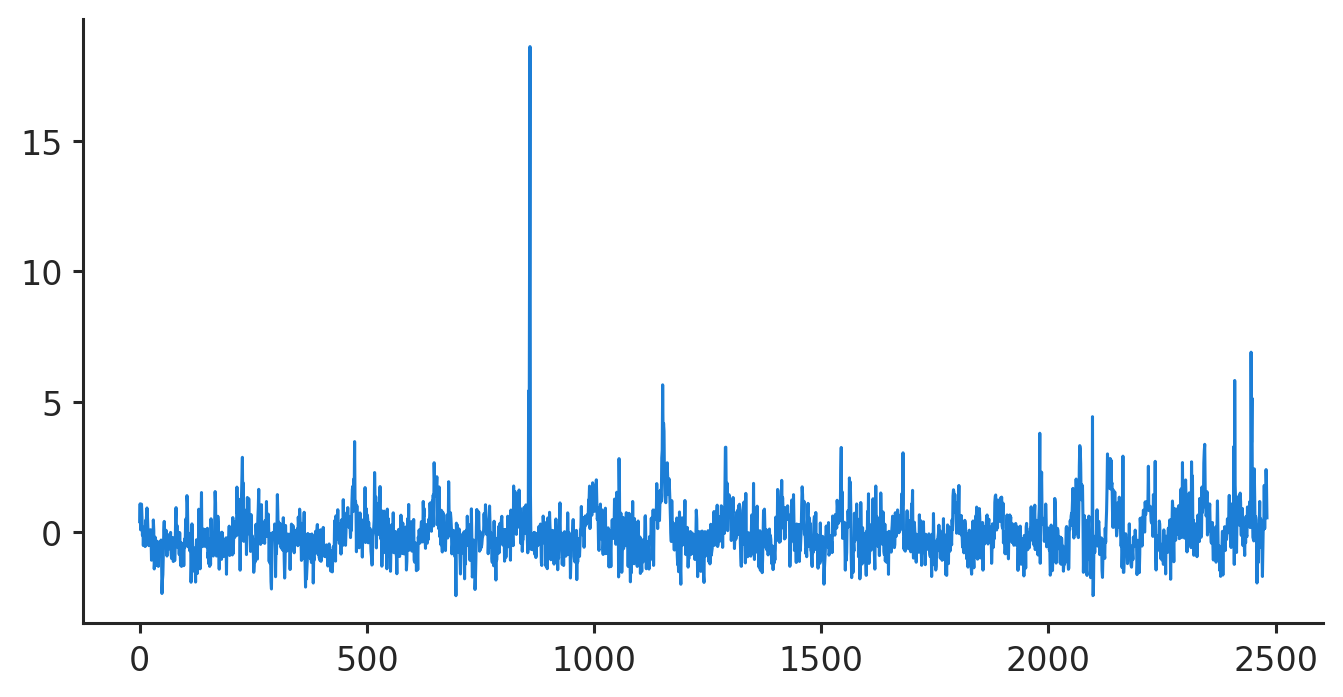

In [99]:
xx = x[~np.isnan(x)]
plt.plot(standardize(xx))

(0.0005, 0.003)

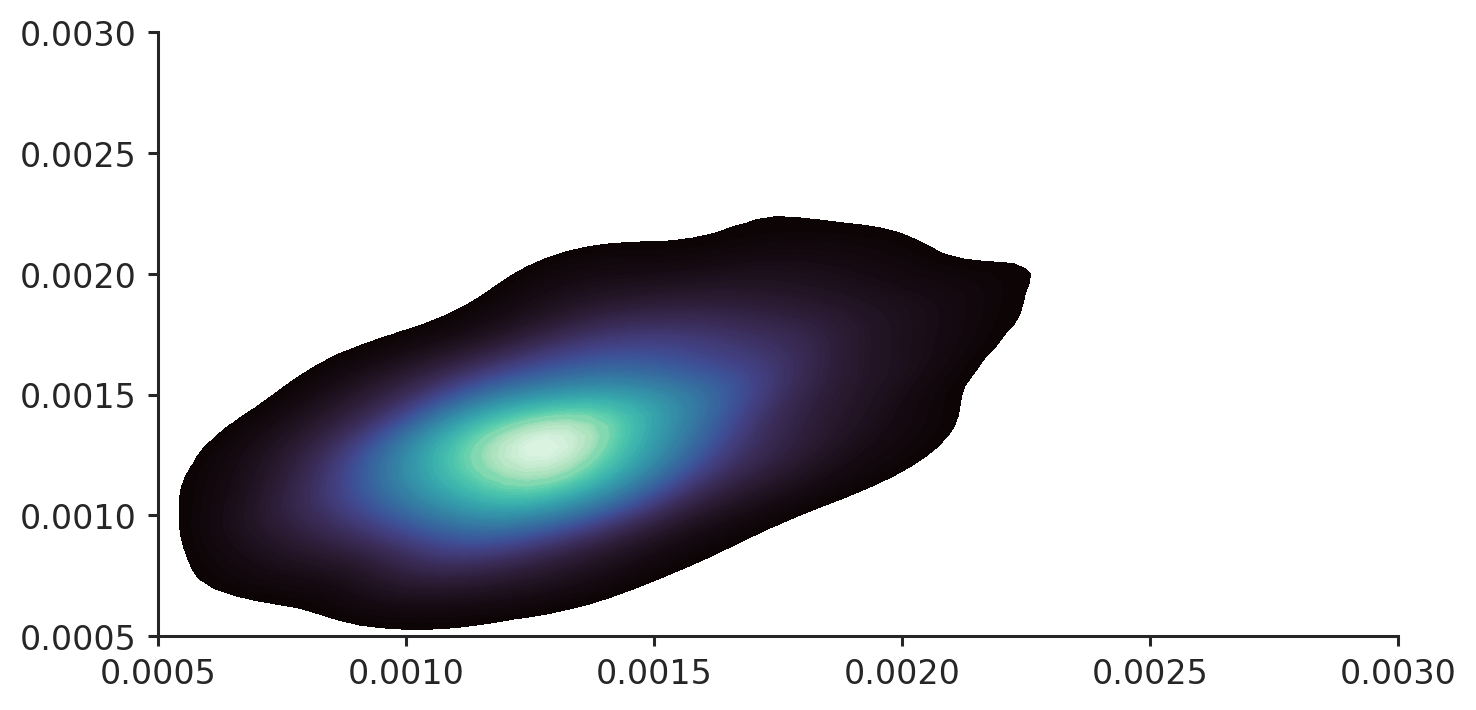

In [98]:
import seaborn as sns
sns.kdeplot(x=xx[:-1:1], y=xx[1::1], fill=True,levels=100, cmap="mako")
plt.ylim(0.0005, 0.003)
plt.xlim(0.0005, 0.003)

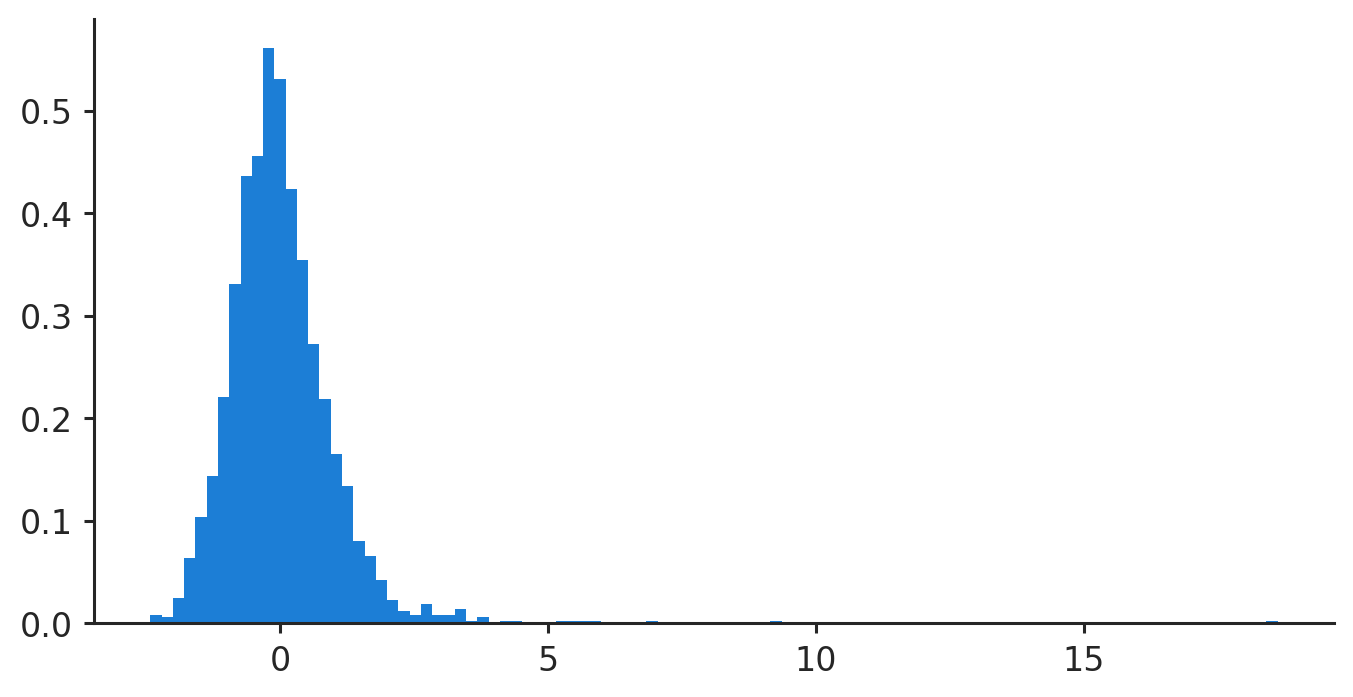

In [73]:
def standardize(x):
    return (x - np.nanmean(x)) / (np.nanstd(x))

_ = plt.hist(standardize(x), 100, density=True)
#z = np.linspace(0.0001, 0.008, 100)
# trimmed mean
#xt = x[(np.nanquantile(x, 0.01) < x) & (np.nanquantile(x, 0.99) > x)]
#plt.plot(z, stats.norm(loc=np.nanmean(xt), scale=np.nanstd(xt)).pdf(z), c='r')

In [341]:
import scipy

In [350]:

# Define the exponentiated quadratic 
def exponentiated_quadratic(xa, xb):
    """Exponentiated quadratic  with σ=1"""
    # L2 distance (Squared Euclidian)
    sq_norm = -0.5 * ~(xa, xb, 'sqeuclidean')
    return np.exp(sq_norm)

def GP(X1, y1, X2, kernel_func):
    """
    Calculate the posterior mean and covariance matrix for y2
    based on the corresponding input X2, the observations (y1, X1), 
    and the prior kernel function.
    """
    # Kernel of the observations
    Σ11 = kernel_func(X1, X1)
    # Kernel of observations vs to-predict
    Σ12 = kernel_func(X1, X2)
    # Solve
    solved = scipy.linalg.solve(Σ11, Σ12, assume_a='pos').T
    # Compute posterior mean
    μ2 = solved @ y1
    # Compute the posterior covariance
    Σ22 = kernel_func(X2, X2)
    Σ2 = Σ22 - (solved @ Σ12)
    return μ2, Σ2  # mean, covariance

In [393]:
S11 = exponentiated_quadratic(yy[:, None], yy[:, None])

In [395]:
S11.sum()

4564948.522396602

In [382]:
X1 = X2 = np.arange(yy.size)[:, None]
y1 = yy

X2 = np.random.uniform(0, yy.size, 1000)[:, None]
mean, Sigma = GP(X1, y1, X2, exponentiated_quadratic)

In [383]:
y2 = np.random.multivariate_normal(mean=mean, cov=Sigma, size=yy.size)


In [389]:
yy.size

2482

In [384]:
y2.shape

(2482, 1000)

(-20.0, -10.0)

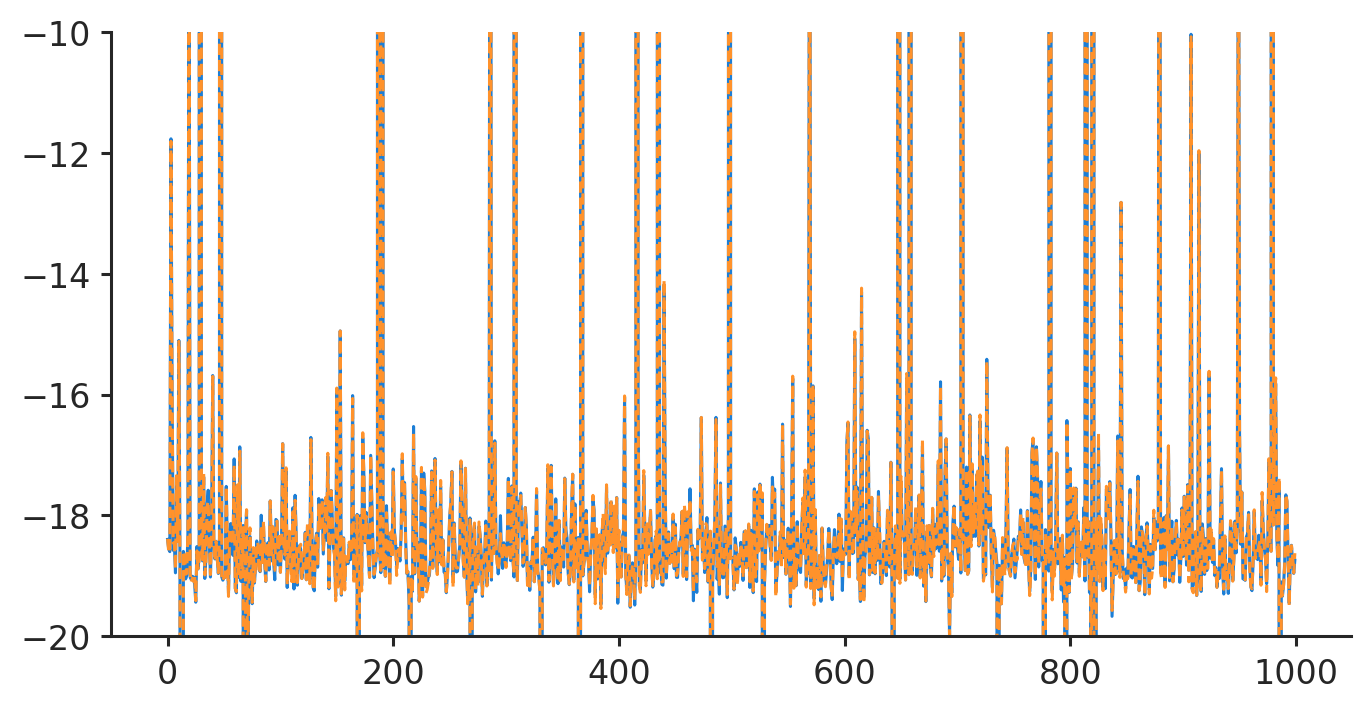

In [390]:
plt.plot(y2[0, :])
plt.plot(y2[10, :], linestyle='dashed')
plt.ylim(-0.2e2, -10)
#plt.xlim(1000, 1500)

In [15]:
from jax import jacfwd, jacrev
import jax.numpy as jnp
from jax.config import config
config.update("jax_enable_x64", True)

In [16]:
def ll_jax(theta, Y, logB, w):
    nS = Y[:, 0]
    nD = Y[:, 1]
    nx, nw, nt, nf = logB.shape
    # mut weight params
    pi0, mu, W = theta[0], theta[1], theta[2:]
    W = W.reshape((nt, nf))
    # interpolate B(w)'s
    logBw = jnp.zeros(nx, dtype=jnp.float32)
    for i in range(nx):
        for j in range(nt):
            for k in range(nf):
                logBw = logBw.at[i].add(jnp.interp(mu*W[j, k], w, logB[i, :, j, k]))
    log_pibar = jnp.log(pi0) + logBw
    llm = nD*log_pibar + nS*jnp.log1p(-jnp.exp(log_pibar))
    return jnp.sum(llm)

def reduce_theta(theta, nt, nf):
    pi0, mu, W = theta[0], theta[1], theta[2:]
    W = W.reshape((nt, nf))
    new_theta = np.empty((nt-1)*nf + 2)
    new_theta[0] = theta[0]
    new_theta[1] = theta[1]
    new_theta[2:] = W[1:, :].flat
    return new_theta

In [477]:
reduce_theta(best_theta, nt, nf)[2:].reshape((nt-1, nf))

array([[0.10875168, 0.01277675, 0.28928304],
       [0.00188802, 0.27006869, 0.0016535 ],
       [0.11227049, 0.13366332, 0.136505  ],
       [0.64403287, 0.31102553, 0.06701897]])

In [27]:
func = partial(ll_jax, Y=Y, logB=B, w=w)

In [39]:
pbr[2:].reshape((nt, nf))

array([[0.82835712, 0.15059037, 0.8546038 ],
       [0.01037829, 0.00309528, 0.0796863 ],
       [0.02685249, 0.00839535, 0.00679748],
       [0.04252227, 0.32217616, 0.00410318],
       [0.09188982, 0.51883812, 0.05480925]])

In [29]:
def hessian(f):
    return jacfwd(jacrev(f))
H = hessian(func)(pbr)

In [36]:
np.linalg.inv(H)

array([[-3.33568149e-17, -6.22371557e-25,  9.88879827e-15,
         2.89261969e-15,  7.41181932e-15, -2.30390861e-14,
        -5.80029072e-15, -7.46702013e-15,  8.43676581e-15,
        -1.41884774e-14, -1.90918076e-14,  6.91570703e-15,
         4.78119622e-14,  3.01006274e-14, -1.39314895e-14,
        -9.02759556e-14, -6.71495010e-14],
       [-6.22371584e-25,  3.20403605e-30, -4.48413880e-20,
        -1.84685844e-22, -3.74429456e-20,  8.93848502e-20,
         2.96933928e-21,  6.50620775e-20, -5.36513621e-20,
         9.81185109e-22, -2.72659719e-20,  2.68845095e-20,
        -8.69480522e-21,  2.46383553e-20, -3.99737768e-21,
         1.71674372e-20, -3.13842122e-20],
       [ 9.88879787e-15, -4.48413886e-20, -7.70209945e-10,
         4.63354907e-10,  1.54329591e-09,  2.42750308e-09,
        -1.13545326e-09, -3.69221087e-09, -2.03443060e-09,
         5.43780598e-10,  2.47509599e-09,  9.95451095e-10,
         4.18420923e-11, -1.28177195e-09, -3.75256775e-10,
        -3.07043900e-10,  7.6

In [30]:
np.linalg.det(H)

1.0512076703300774e+168

In [32]:
np.diag(H), np.trace(H)

(array([-3.51438155e+16, -1.85047421e+26, -2.37166355e+10, -9.76800624e+09,
        -1.77300574e+09, -6.93015047e+09, -2.73782657e+09, -5.35288471e+08,
        -2.98885663e+09, -7.94022202e+08, -1.81625694e+08, -4.45456489e+09,
        -3.97469952e+08, -1.85523701e+08, -5.99753936e+09, -3.39225295e+08,
        -2.08804168e+08]),
 -1.8504742136282053e+26)

In [33]:
np.linalg.eigvals(H)

array([-1.85047421e+26, -3.27946327e+16,  2.85763603e+13, -1.15472476e+10,
       -7.41662959e+09, -1.77473724e+09, -8.83774367e+08, -2.48308597e+08,
       -1.77192139e+08, -6.47516849e+07, -4.82963064e+07, -3.69071396e+07,
       -2.02386331e+07, -1.48106072e+07, -6.55119792e+06, -3.31574293e+06,
       -1.36479704e+06])

In [23]:
H

DeviceArray([[-3.51427253e+16,  5.58184269e+20, -6.02452491e+12,
               0.00000000e+00,  0.00000000e+00, -3.53183963e+12,
               6.26224343e+11,  4.65830952e+11, -3.89518186e+12,
               5.12544206e+11,  3.90084117e+11,  1.99270389e+12,
               1.86615426e+12,  1.48176740e+12],
             [ 5.58184270e+20, -1.59356295e+26,  8.21108051e+19,
               0.00000000e+00,  0.00000000e+00,  5.63878319e+19,
              -5.37363881e+18, -4.03185896e+18,  7.06608088e+19,
              -2.55925150e+18, -1.92447282e+18,  6.94763190e+19,
              -2.94119335e+18, -2.22764720e+18],
             [-6.02452491e+12,  8.21108051e+19, -2.75036778e+10,
               0.00000000e+00,  0.00000000e+00, -1.70334486e+10,
               2.41440266e+09,  1.99666700e+09, -2.15067243e+10,
               1.40984841e+09,  1.16747642e+09, -1.64242305e+10,
               2.61120346e+09,  2.06314961e+09],
             [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
        

In [512]:
h = np.copy(H)

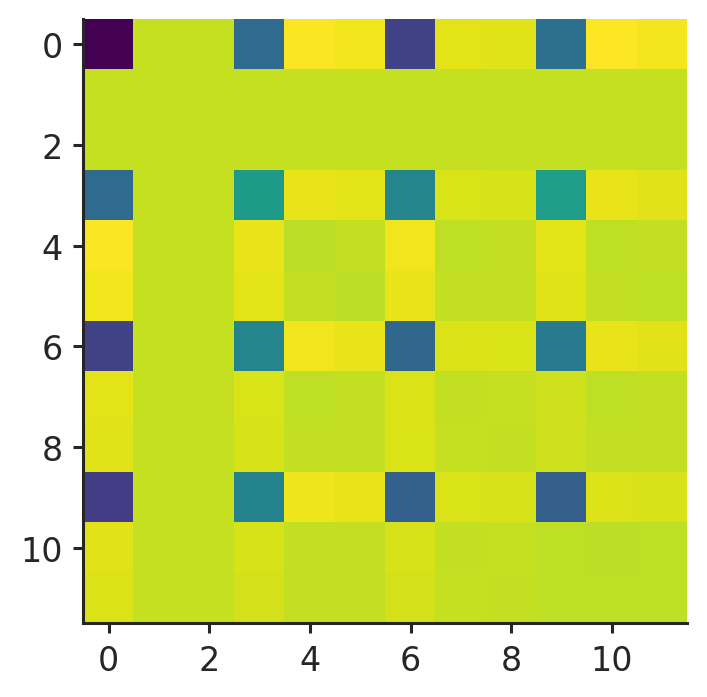

In [513]:
h[1,1] = np.nan
plt.imshow(h[2:, 2:])

In [489]:
h

array([[-3.6085310e+16,  5.9485261e+21, -8.0336600e+13,  0.0000000e+00,
         0.0000000e+00, -8.0336600e+13,  5.7061791e+12,  0.0000000e+00,
        -6.7394077e+13,  2.8951514e+12,  2.2669238e+12, -6.2809639e+13,
         4.0863492e+12,  3.1633847e+12],
       [ 5.9485030e+21,            nan,  8.3505093e+19,  0.0000000e+00,
         0.0000000e+00,  8.3505093e+19, -5.3629845e+18,  0.0000000e+00,
         7.2294636e+19, -2.4923260e+18, -1.8356764e+18,  7.2075842e+19,
        -2.6402614e+18, -1.9806552e+18],
       [-8.0336382e+13,  8.3505076e+19, -5.8563808e+11,  0.0000000e+00,
         0.0000000e+00, -5.8563808e+11,  3.6496060e+10,  0.0000000e+00,
        -5.0546144e+11,  1.6714159e+10,  1.3106711e+10, -5.0641623e+11,
         1.7954982e+10,  1.3774949e+10],
       [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
         0.0000000e+00,  0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
         0.00

In [457]:
best_theta

array([1.82532621e-03, 4.56428765e-09, 1.33056940e-01, 2.72465702e-01,
       5.05539491e-01, 1.08751677e-01, 1.27767539e-02, 2.89283038e-01,
       1.88802334e-03, 2.70068688e-01, 1.65349505e-03, 1.12270486e-01,
       1.33663322e-01, 1.36505002e-01, 6.44032873e-01, 3.11025534e-01,
       6.70189732e-02])

In [451]:
H[0, 0]

DeviceArray(-3.1337838e+16, dtype=float32)

In [455]:
np.linalg.det(H[:2, :2])

inf

In [437]:
H

DeviceArray([[ 3.60858514e+16, -5.64452974e+21, -5.53158443e+13,
              -1.06708095e+13, -6.79964364e+12, -2.54713749e+13,
              -5.23656390e+12, -3.43430319e+12,  0.00000000e+00,
              -2.72381457e+12,  0.00000000e+00, -9.05499273e+12,
              -2.08962585e+12, -1.54509089e+12, -8.21807861e+12,
              -1.91346639e+12, -1.45391550e+12],
             [-5.64451397e+21,  2.23070263e+27,  6.22356875e+19,
               1.21446645e+19,  9.17880553e+18,  2.56130156e+19,
               5.36386962e+18,  4.10532298e+18,  0.00000000e+00,
               2.48272199e+18,  0.00000000e+00,  6.37711686e+18,
               1.47537830e+18,  1.13067488e+18,  4.81834748e+18,
               1.12190318e+18,  8.51826705e+17],
             [-5.53158066e+13,  6.22361185e+19,  3.04854532e+11,
               4.40190239e+10,  2.66589389e+10,  1.29732215e+11,
               2.01709261e+10,  1.27086111e+10,  0.00000000e+00,
               9.73056410e+09,  0.00000000e+00,  3.161175

In [435]:
np.linalg.inv(H)

LinAlgError: Singular matrix